# Home Credit Loan Defaulter Prediction - Preprocessing and Modelling

## Capstone Three : Springboard Data Science career track

**Notebook by Md Saimoom Ferdous**

### Problem Statement

Home Credit Group is one of the largest non-banking financial institution headquartered in Netherlands. It focuses on handing out credits to the population with little or no credit history. Mjority of the population living in remote communities needs micor credit, but they do not have anough credit history that will build confidence in lending the credit. 

Other than the credit history, what are the other available characteristics  (social, demographical) can provide insights into the client groups who would be able to repay the credit. Does repaying credit correlates with age group, occupation, shopping habit or any other unseen traits which can be discovered by data analysis?

Once the features that lead to repaying credits are known, which are the dominant features in deterining credit repayment?


Machine learning algorithms can be trained to predict default vs non-default clients based on theri very little information available. These come with two problems. Clients who really in need of the credit may often be prioly misclassified as deafulter. This phenomena is called false positive. For Home Credit Group this would derail their purpose if anyone deserving does not get the credit.  On the other hand, clients with real tendency for loan defaulter may be given green light for the credit as the algorithm would misclassify as non-defaulter. These phenomena is called false negative. This is also higly discouraging as registering loan defaulters in disguise would cripple organizations financial health in the medium to longer terms. It is essential to design machine learning algorithm for loan defulter in such a way to minimize false positiove/negative whereas maximizing true positive/negative rate. 


### The Data

- Data has been sourced from a Kaggle competition, consisting of thousands of client home loan, credit records (https://www.kaggle.com/c/home-credit-default-risk/data).
- Data wrangling, EDA and pre-processing will be done to get the data training ready for modelling stage

### Question(s) of Interest

EDA will look to answer following questions:
- What (%) of the population is likely to repay loan
- What loan type/gender group more prone to loan defaulting
- Do most of the clients own car/house?
- What education/working background clients come from?
- What are their marital status?
- How many children most clients have and family members?
- What are their income/credit/annuity distribution
- What age distributiton the cliens have

### 1. Data Wrangling

This step consists of Data Collection, Data Definitions, and Data Cleaning.

  * Data Collection
      - Data loading
  * Data Definition
      - Column names
      - Data types (numeric, categorical, timestamp, etc.)
      - Description of the columns
      - Count or percent per unique values or codes (including NA)
      - The range of values or codes  
  * Data Cleaning
      - NA or missing data
      - Duplicates

### 2. Exploratory Data Analysis

Conducted EDA on Home Credit Group loan data to examine relationships between variables and other patterns in the data.
- Explore distribution of categorical variables
- Explore distribution of numerical variables
- Anomalies and outliers
- Finding correlated variables and feature removal
- Feature creation

### 3. Pre-processing

Get the data ready for modelling stage, including:
- Create dummy features for categorical variables
- Standardize the magnitude of numeric variables
- Balance the data 
- Shuffle the balanced data 
- Split into training, validation and test data

### 4. Modelling

- Train, hyperparameter optimization and assess model performances with deep neural network (Tensorflow 2.0), Random Forest, Gradient Boosting Mehtod (GBM), XGBoost and Ensemble methods
- Model performances were assessed and compared with area under curve (AUC), Receiver Operating Characteristics (ROC) metrics for binary classification
- Threshold values were tuned to get better balance between false positive and false neganive ratios
- Save best model parameters for future use

### 5. Conclusion

- Summarizes the overall project, findings and results
- Recommends future areas of improvements


# 3. Pre-processing

In [323]:
#load python packages

import os
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline


# Set seed value for model reproducibility
seed_value= 1
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
seed_value += 1
# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)
seed_value += 1
# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)
seed_value += 1

# tensorflow
# 4. Set `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dropout
tf.random.set_seed(seed_value)

# sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.utils import shuffle

# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# GBM
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# XGBoost related libraries
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

# roc curve and auc score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# to save the model parameters
import pickle

# to ignore warning message
import warnings
warnings.filterwarnings('ignore')

## 3.1 Load Data from the EDA Step
Dataframe with and without additional features will be loaded

In [4]:
# load data

# Original dataframe
df_base = pd.read_csv('data/homecredit_baseline_EDA.csv', index_col=0)

# With additional features
df = pd.read_csv('data/homecredit_extended_EDA.csv', index_col=0)

- We will work with the dataframe with extra features as of now
- Extra features will be saved and used to check model performance without the additional features

In [5]:
# Save extra features
additional_features = list(set(df.columns)-set(df_base.columns))

In [324]:
# look at the dataframe
df.head()

NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY NAME_TYPE_SUITE  \
0         Cash loans           M            N               Y   Unaccompanied   
1         Cash loans           F            N               N          Family   
2    Revolving loans           M            Y               Y   Unaccompanied   
3         Cash loans           F            N               Y   Unaccompanied   
4         Cash loans           M            N               Y   Unaccompanied   

  NAME_INCOME_TYPE            NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
0          Working  Secondary / secondary special  Single / not married   
1    State servant               Higher education               Married   
2          Working  Secondary / secondary special  Single / not married   
3          Working  Secondary / secondary special        Civil marriage   
4          Working  Secondary / secondary special  Single / not married   

   NAME_HOUSING_TYPE WEEKDAY_APPR_PROCESS_START  ... ANNUNITY_OVER_INCOME  \
0  House / apartment                  WEDNESDAY  ...             0.121978   
1  House / apartment                     MONDAY  ...             0.132217   
2  House / apartment                     MONDAY  ...             0.100000   
3  House / apartment                  WEDNESDAY  ...             0.219900   
4  House / apartment                   THURSDAY  ...             0.179963   

  CREDIT_OVER_INCOME ANNUNITY_OVER_CREDIT EMPLOYED_OVER_AGE  \
0           2.007889             0.060749          0.067329   
1           4.790750             0.027598          0.070862   
2           2.000000             0.050000          0.011814   
3           2.316167             0.094941          0.159905   
4           4.222222             0.042623          0.152418   

   APARTMENT_OVER_INCOME  CARAGE_OVER_AGE  BUILD_OVER_AGE   EXT_3_2   EXT_3_1  \
0           1.219753e-07              0.0        0.023888  0.036649  0.011573   
1           3.551852e-07              0.0        0.017330  0.365301  0.182735   
2           8.548148e-07              0.0        0.014420  0.405575  0.273626   
3           4.274074e-07              0.0        0.014452  0.426275  0.241505   
4           4.748971e-07              0.0        0.013779  0.215919  0.401310   

    EXT_2_1  
0  0.021834  
1  0.193685  
2  0.208496  
3  0.239692  
4  0.193593  

[5 rows x 95 columns]

## 3.2 Convert Categorical Variables into Dummy Variables
Many machine learning models can not handle categorial variables during training. For example neural network. We will also run algorithms that can handle categorical variables. It is important to systematically convert categorical variables into meaningful numeric variables. First we will determine for every categorical comuns how many unique categories are there. Two of the most popular techniques are label encoding and one hot encoding. Label encoder is used where sub categories needed weighting. For example, 'low', 'medium', 'high'. Whereas, one hot encoding splits the catogories and put equal weight. We will use one hot encoding instead of label encoding as none of the categorical variables needed weighting according to the sub-categories. Too much subcategories is also undesirable. It will cause 'curse of dimensionality' problem. WHich means too much features reduces algorithms ability to cluster similar things together. Features with more than 10 subcategories will be deleted as a cardinal to avoid 'curse of dimensionality' situation.          

In [7]:
# Find out number of unique categories for each categorical variables
print('Number of unique variables for the categorical columns:\n', df.select_dtypes(include=['object']).nunique())

Number of unique variables for the categorical columns:
 NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64


In [8]:
# Drop columns with more than 10 subcategories

df.drop(columns=['OCCUPATION_TYPE','ORGANIZATION_TYPE'], inplace = True)

In [9]:
# Take note of the categorical columns as we will be using dataset with/without one-hot-encoding during training

categorical_columns = list(df.select_dtypes(include=['object']).columns.values)

The whole dataframe will be parsed into follwoing groups to have better manueaverablity: [additional features][original categorical features][one hot encoded features][numerical features][target variable]

In [10]:
# Dataframe with Additioanl features

df_additional_features = df[additional_features]

In [11]:
# Dataframe with original categorical features

df_categorical = df[categorical_columns]

In [12]:
# Dataframe with one-hot-encoded features

df_one_hot_code = pd.get_dummies(df[categorical_columns])
df_one_hot_code.head(3)

NAME_CONTRACT_TYPE_Cash loans  NAME_CONTRACT_TYPE_Revolving loans  \
0                              1                                   0   
1                              1                                   0   
2                              0                                   1   

   CODE_GENDER_F  CODE_GENDER_M  CODE_GENDER_XNA  FLAG_OWN_CAR_N  \
0              0              1                0               1   
1              1              0                0               1   
2              0              1                0               0   

   FLAG_OWN_CAR_Y  FLAG_OWN_REALTY_N  FLAG_OWN_REALTY_Y  \
0               0                  0                  1   
1               0                  1                  0   
2               1                  0                  1   

   NAME_TYPE_SUITE_Children  ...  HOUSETYPE_MODE_terraced house  \
0                         0  ...                              0   
1                         0  ...                              0   
2                         0  ...                              0   

   WALLSMATERIAL_MODE_Block  WALLSMATERIAL_MODE_Mixed  \
0                         0                         0   
1                         1                         0   
2                         1                         0   

   WALLSMATERIAL_MODE_Monolithic  WALLSMATERIAL_MODE_Others  \
0                              0                          0   
1                              0                          0   
2                              0                          0   

   WALLSMATERIAL_MODE_Panel  WALLSMATERIAL_MODE_Stone, brick  \
0                         0                                1   
1                         0                                0   
2                         0                                0   

   WALLSMATERIAL_MODE_Wooden  EMERGENCYSTATE_MODE_No  EMERGENCYSTATE_MODE_Yes  
0                          0                       1                        0  
1                          0                       1                        0  
2                          0                       1                        0  

[3 rows x 64 columns]

In [13]:
# Dataframe with Numerical features

df_num = df.select_dtypes(exclude=['object'])
df_num.drop(columns='TARGET', inplace = True)

In [14]:
# Dataframe with Target variable

df_target = df['TARGET']

Determine number of features from each categories that will help parsing the dataframe in later part to see the effect of different features in model training

In [15]:
print('Number of columns in df_additional_features: ',df_additional_features.shape[1])
print('Number of columns in df_categorical: ',df_categorical.shape[1])
print('Number of columns in df_one_hot_code: ',df_one_hot_code.shape[1])
print('Number of columns in df_num: ',df_num.shape[1])

Number of columns in df_additional_features:  13
Number of columns in df_categorical:  14
Number of columns in df_one_hot_code:  64
Number of columns in df_num:  80


## 3.3 Standardize the Magnitude of Numerical Variables
This is applied to avoid bias when there are differences in magnitude of the numerical variables. In this case, we have seen stark differences between numeric variables. For example annual income, annuity and credits differ sharply in magnitude from other variables. We will scale every numeric variables except the booleans one.

### Standardize the Numerical Variables

In [16]:
# remove boolean variables
bool_cols = [col for col in df_num
             if np.isin(df[col].dropna().unique(), [0, 1]).all()]
df_num_only = df_num.drop(columns=bool_cols)
df_num_only.head(3)


CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0             0          202500.0    406597.5      24700.5   
1             0          270000.0   1293502.5      35698.5   
2             0           67500.0    135000.0       6750.0   

   REGION_POPULATION_RELATIVE  REGION_RATING_CLIENT  HOUR_APPR_PROCESS_START  \
0                    0.018801                     2                       10   
1                    0.003541                     1                       11   
2                    0.010032                     2                        9   

   EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  ...  ANNUNITY_OVER_INCOME  \
0      0.083037      0.262949      0.139376  ...              0.121978   
1      0.311267      0.622246      0.587068  ...              0.132217   
2      0.375053      0.555912      0.729567  ...              0.100000   

   CREDIT_OVER_INCOME  ANNUNITY_OVER_CREDIT  EMPLOYED_OVER_AGE  \
0            2.007889              0.060749           0.067329   
1            4.790750              0.027598           0.070862   
2            2.000000              0.050000           0.011814   

   APARTMENT_OVER_INCOME  CARAGE_OVER_AGE  BUILD_OVER_AGE   EXT_3_2   EXT_3_1  \
0           1.219753e-07              0.0        0.023888  0.036649  0.011573   
1           3.551852e-07              0.0        0.017330  0.365301  0.182735   
2           8.548148e-07              0.0        0.014420  0.405575  0.273626   

    EXT_2_1  
0  0.021834  
1  0.193685  
2  0.208496  

[3 rows x 46 columns]

In [17]:
# Scale all numerical column values except target and boolean variables
num_scaled = preprocessing.scale(df_num_only)

# Putback scaled data into dataframe
df_num_only.iloc[:,:] = num_scaled

# Numerical dataframe consisting of scaled and boolean data
df_scaled_num = pd.concat([df_num_only, df_num[bool_cols]], axis = 1)
df_scaled_num = df_scaled_num.add_suffix('_scaled')

### Combine Other Variables with Scaled Variable to form a Dataset

In [18]:
# Combine scaled features with other features and arrange them side by side
inputs_scaled_df = pd.concat([df_additional_features, df_categorical, df_one_hot_code, df_num, df_scaled_num], axis = 1)
targets_df = df_target

## 3.4 Balance the Data
From EDA step, we have seen deafaulter and non-defaulter percentage is around 92% vs 8% which is highly imbalanced. Imbalance data set introduces high percentage of biases towards majority class during training. Three popuar methods to combat imbalanced data:
- Over-sampling
- Under-sampling
- Synthetic data creation

We will be using under-sampling to balance the data to 50-50 ratio as it will keep the integrity of the data. 

In [21]:
# Take row indices that will make target population 50-50 for loan defaulter vs non defaulter

num_one_targets = int(np.sum(targets_df))
zero_targets_counter = 0
indices_to_remove = []

for i in range(targets_df.shape[0]):
    if targets_df.values[i] == 0:
        zero_targets_counter +=1
        if zero_targets_counter > num_one_targets:
            indices_to_remove.append(i)
            

In [22]:
# Delete rows to make dataframe with 50-50 balanced target distribution
inputs_scaled_equal_df = inputs_scaled_df.drop(indices_to_remove)
inputs_scaled_equal_df.reset_index(drop = True, inplace = True)
targets_equal_df = targets_df.drop(indices_to_remove)

## 3.5 Shuffle the Data
In many cases data is collected in orderly fashion. This becomes particularly problemtic when running batch processing for model training. We will shuffle the data to be in the safe side to spread out target variables as much as possible.

In [23]:
# Shuffle the 'features' and 'target' variables
inputs_shuffled_df = shuffle(inputs_scaled_equal_df, random_state = 0)
targets_shuffled_df = targets_equal_df.iloc[inputs_shuffled_df.index].to_frame('TARGET')

# Reset index
inputs_shuffled_df.reset_index(drop=True, inplace=True)
targets_shuffled_df.reset_index(drop=True, inplace=True)

## 3.6 Split Data into Train, Validation and Test Set
Split the scaled, balanced dataset into train, validation and test dataset. We will split by 80-10-10 ratio.

In [24]:
# Total samples
samples_count = inputs_shuffled_df.shape[0]

# Count number of train, validation and test samples to split by 80-10-10 ratio 
train_samples_count = int(0.8 * samples_count)
validation_samples_count = int(0.1 * samples_count)
test_samples_count = samples_count - train_samples_count - validation_samples_count

In [25]:
# Train set for inputs and targets
train_inputs = inputs_shuffled_df.iloc[:train_samples_count]
train_targets = targets_shuffled_df.iloc[:train_samples_count]

# Validation set for inputs and targets
validation_inputs = inputs_shuffled_df.iloc[train_samples_count:train_samples_count+validation_samples_count]
validation_targets = targets_shuffled_df.iloc[train_samples_count:train_samples_count+validation_samples_count]

# Test set for inputs and targets
test_inputs = inputs_shuffled_df.iloc[train_samples_count+validation_samples_count:]
test_targets = targets_shuffled_df.iloc[train_samples_count+validation_samples_count:]

- The data was made 50-50 balanced. After spliting into train, validation and test set, it is important to check the split data set is also balanced. Lets check on that.

In [26]:
# Lets check how many percentage of the three set contains targets with loan deafulter population

print('Loan defaulter percentage in train set: {:.2f}%'.format(100*(np.sum(train_targets.values) / train_samples_count)))
print('Loan defaulter percentage in validation set: {:.2f}%'.format(100*(np.sum(validation_targets.values) / validation_samples_count)))
print('Loan defaulter percentage in test set: {:.2f}%'.format(100*(np.sum(test_targets.values) / test_samples_count)))

Loan defaulter percentage in train set: 50.09%
Loan defaulter percentage in validation set: 49.71%
Loan defaulter percentage in test set: 49.57%


- The train, validation and test set are well balanced

## 3.7 Save Pre-processed Data
Save the scaled, balanced and shuffled dataset into train, validation, test subset for the use in modelling stage.

In [27]:
# Save data in .csv format

# Training data
train_df = pd.concat([train_inputs, train_targets], axis=1)
train_df.to_csv('data/homecredit_train.csv')

# Validation data
validation_df = pd.concat([validation_inputs, validation_targets], axis=1)
validation_df.to_csv('data/homecredit_validation.csv')

# Test data
test_df = pd.concat([test_inputs, test_targets], axis=1)
test_df.to_csv('data/homecredit_test.csv')

# 4. Modelling

## 4.1 Data Load

In [19]:
# Load train, validation and test data saved after pre-processing step
train_df = pd.read_csv('data/homecredit_train.csv', index_col=0)
validation_df = pd.read_csv('data/homecredit_validation.csv', index_col=0)
test_df = pd.read_csv('data/homecredit_test.csv', index_col=0)

In [20]:
train_df.head(3)

CREDIT_OVER_INCOME  CNT_CHILDREN_ANOM  EMPLOYED_OVER_AGE   EXT_3_2  \
0            4.000000                  0           0.095678  0.182540   
1            1.647511                  0           0.039555  0.025745   
2            3.315000                  0          -0.000000  0.386090   

   YEARS_EMPLOYED_ANOM  APARTMENT_OVER_INCOME  CNT_FAM_MEMBERS   EXT_2_1  \
0                    0           3.205556e-07                0  0.019306   
1                    0           2.291358e-07                0  0.054457   
2                    1           2.289683e-07                0  0.324069   

   BUILD_OVER_AGE  CARAGE_OVER_AGE  ...  FLAG_DOCUMENT_16_scaled  \
0        0.023505              0.0  ...                        0   
1        0.024635              0.0  ...                        0   
2        0.015838              0.0  ...                        0   

   FLAG_DOCUMENT_17_scaled  FLAG_DOCUMENT_18_scaled FLAG_DOCUMENT_19_scaled  \
0                        0                        0                       0   
1                        0                        0                       0   
2                        0                        0                       0   

  FLAG_DOCUMENT_20_scaled FLAG_DOCUMENT_21_scaled CNT_CHILDREN_ANOM_scaled  \
0                       0                       0                        0   
1                       0                       0                        0   
2                       0                       0                        0   

  YEARS_EMPLOYED_ANOM_scaled CNT_FAM_MEMBERS_scaled TARGET  
0                          0                      0      1  
1                          0                      0      1  
2                          1                      0      1  

[3 rows x 252 columns]

This dataset contains all the features we will be exploring. Depending on the models needs, dataset will berearranged at the beginning of every sections.

## 4.2 Base Deep Neural Net Model

We will be using Tensorflow 2.0 library to build deep learning model for loan defaulter classification. A brief discussion about different optimization algorithms, loss functions, metrices are below:

**Optimizers**

Gradient Descent (GD): Iterates through whole training set. Updates once in a epoch. Slow in speed
Stochastic Gradient Descent (SGD): Updates weights multiple times in a epoch defined by batch size. Faster in speed
Adaptive Momentum (Adam): Adaptive learning rate coupled with momentum help the algorithm overcome any local peak and ensure reaching the minimum global peak
We will choose Adam for best performance.

**Loss Function**

Cross-entropy would be the choice for classification problem. Three options in Tensorflow 2.0. They are: binary, categorical and sparse categorical cross entropy. Binary expects the data is binary encoded. Categorical expects the data is one hot coded. Sparse can one hot code data during the training. To be in safe side we will apply sparse categorical cross entropy.

**Metrics**

Confusion matrix is used get a full picture when assessing the performance of a classification model.
<img src="Figures/Model/Model_confusion_matrix.PNG">
Image taken from: Stanford.edu

Other useful metrics can be derived based on the elements of the confusio matrix

- **Accuracy**: Measures the fraction of correctly classified samples from every categories.

$ (TP+TN)/(TP+FP+FN+TN) $

TP = Predicting actual positive samples as positive
FP = Predicting a sample positive but actually negative e.g. predicitng a client loan defaulter whereas he is able to repay loans
FN = Predicting a sample negative but actually positive e.g. predicitng a client non-defaulter whereas he would not be able to repay
TN = Predicting actual negative samples as negative



- **ROC curve**: Measures the ability of a model to correctly classify samples at differenct threshold levels. It plots two parameters, FPR vs TPR

$ FPR = FP/(FP+TN) $ 

$ TPR = TP/(TP+TN) $


For a binary classifier, ROC curve shows the ability to correctly classify between 0's and 1's at different threshold levels

- **AUC score**: Is a single number, that measures the total integral area under the ROC curve which is a measure of separibility between classes. Higher the AUC score better is the classifiers at distinguising 0's as 0's and 1's and 1's. For or case, higher is the AUC better the model to distinguish between loan defaulters and non defaulters. An excellent illustration has been provided in the following link:
[https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5]
<img src="Figures/Model/Model_auc_1.PNG">
The positive class (red) and negative class (green) distributions are 100% seperable (although ideal case) which is the score of AUC.. It means 100% probability to be able to separete between two class. In our cases 100% chances of separating between loan defaulter vs non-defaulter class. 
<img src="Figures/Model/Model_auc_p5.PNG">
In the above figure, the two distribution completely overlap. The chances of separability between two classes is 50% (AUC score). This is the worst possible performance a classifier can have.

- **Precision**: Measures the ratio between actual positive prediction over total positive prediction
$ Precision = TP/(TP+FP) $

- **Recall**: Measures the ratio between actual positive prediction over total actual positives
$ Recall = TP/(TP+FN) $

- **F1-score**: Harmonic mean of precision and recall. Useful for imbalanced data. 
$ F1 = 2*Precision*Recall/(Precision + Recall) $

We will be using mainly AUC score for assessing our models, in addition to Accuracy and ROC curve.

**Dataset Preparation**
In addition to training data, following dataset are required and their reasoning.

**Validation Set**

Make sure the model parameters (weights, biases) do not overfit

**Test Set**

Make sure the model hyperparameters (width, height, batch size etc) do not overfit


### Original Dataset
Keep one-hot-encoded feature and remove the categorical features to avoid duplication.

In [39]:
# Columns to keep
columns_to_keep = list(df_additional_features.columns)+ list(df_one_hot_code.columns)+list(df_scaled_num.columns)
columns_to_keep = list(set(columns_to_keep)-set(['TARGET']))

# Train set
train_inputs = train_df[columns_to_keep]
train_targets = train_df['TARGET']

# Validation set
validation_inputs = validation_df[columns_to_keep]
validation_targets = validation_df['TARGET']

# Test set
test_inputs = test_df[columns_to_keep]
test_targets = test_df['TARGET']

### Model Development
A baseline deep learning model will be developed with two hidden layers.'ReLu' activation functions will be used in the hidden layers. In the output layer, 'softmax' activation function will be used to get the probabilities of binary classes. Different activation functions will be tweaked in the later part of this section.

In [40]:
# Define a baseline deep learning model 

def tf_model_train_base(train_inputs, train_targets, validation_inputs, validation_targets, test_inputs, test_targets):
    '''Function to train model based on input training data'''
    # Input/output layers size
    input_size = train_inputs.shape[0]
    output_size = 2
    
    # Hidden layer size
    hidden_layer_size = 50
    
    # Model structure
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 1st hidden layer
        tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 2nd hidden layer
        tf.keras.layers.Dense(output_size, activation='softmax') # 'softmax' activation is suitable for classifier
    ])
    
    # Optimizer, loss function and metrics
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    ### Training
    # Batch size
    batch_size = 100
    # Number of training epochs
    max_epochs = 100
    
    # Early stopping: Allow for 2 instances of training after minimum loss point reached for for train/validation loss
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)
    
    
    # fit the model
    train_mod = model.fit(train_inputs.values, # train inputs
              train_targets.values, # train targets
              batch_size=batch_size, # batch size
              epochs=max_epochs, # number of iteration the training will run, unless early stopping kicks in
              callbacks=[early_stopping], # early stopping
              validation_data=(validation_inputs.values, validation_targets.values), # validation data
              verbose = 2 # print minimum information during training
             )  
    
    return train_mod, model


In [43]:
# Train the baseline deep neural net model
history_base, model_base = tf_model_train_base(train_inputs, train_targets, validation_inputs, validation_targets,test_inputs, test_targets)

Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 2s - loss: 0.2549 - accuracy: 0.8979 - val_loss: 0.1902 - val_accuracy: 0.9372
Epoch 2/100
39720/39720 - 1s - loss: 0.1823 - accuracy: 0.9364 - val_loss: 0.2029 - val_accuracy: 0.9255
Epoch 3/100
39720/39720 - 1s - loss: 0.1746 - accuracy: 0.9394 - val_loss: 0.1817 - val_accuracy: 0.9406
Epoch 4/100
39720/39720 - 1s - loss: 0.1692 - accuracy: 0.9419 - val_loss: 0.1811 - val_accuracy: 0.9402
Epoch 5/100
39720/39720 - 1s - loss: 0.1644 - accuracy: 0.9433 - val_loss: 0.1833 - val_accuracy: 0.9394
Epoch 6/100
39720/39720 - 1s - loss: 0.1600 - accuracy: 0.9453 - val_loss: 0.1799 - val_accuracy: 0.9414
Epoch 7/100
39720/39720 - 1s - loss: 0.1560 - accuracy: 0.9462 - val_loss: 0.1802 - val_accuracy: 0.9386
Epoch 8/100
39720/39720 - 1s - loss: 0.1534 - accuracy: 0.9467 - val_loss: 0.1922 - val_accuracy: 0.9321


The gap between training and test accuracy is the amount of overfitting in the model

In [44]:
# Plot Loss vs Epoch for base deep neural net model

def loss_plot(model, filename):
    '''function to plot loss vs epoch given the trained model'''
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(model.history['accuracy'], label = 'Train',linewidth=4)
    ax.plot(model.history['val_accuracy'], label = 'Validation',linewidth=4)
    ax.set_title('Model Loss',fontsize=15)
    ax.set_ylabel('Loss (linear scale)',fontsize=15)
    #ax.set_ylim([0,1])
    ax.set_xlabel('Epoch')
    plt.legend(['Train', 'Validation'], fontsize=15)
    plt.savefig('figures/Model/'+filename+'.png')
    plt.show()
    print('Validation accuracy is: {:.2f}%'.format(100*model.history['val_accuracy'][-1]))

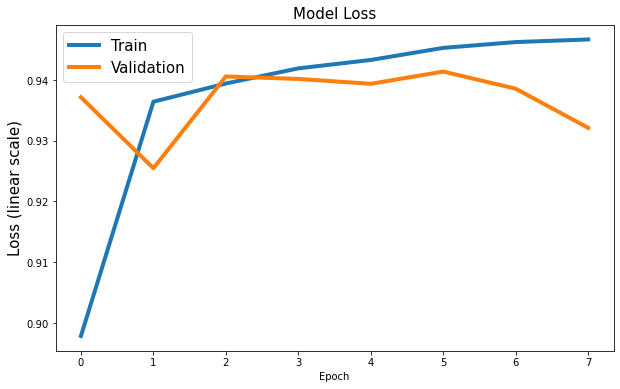

Validation accuracy is: 93.21%


In [45]:
loss_plot(history_base, 'base_model_lossVSepoch')

- The model stopped training just at the onset of dropping validation accuracy by 2 steps (early stop criteria)
- If the validation accuracy is comparable to test accuracy than it confirms the model did not overfit


### Metrics

For the binary classification problem, best metric would be AUC score along with accuracy measure. Couple of functions will be written to save and plot model metrics (accuracy, AUC, FPR, TPR)

#### AUC Score

In [172]:
# Function to calculate model metrices (Accuracy, AUC, FPR, TPR)

def model_metrics(train_inputs, train_targets, validation_inputs, validation_targets, test_inputs, test_targets):
    
    '''function to calculate and return specified model metrics'''
    
    # run model for 10 times and take average
    accuracy_avg=[]
    auc_avg=[]
    y_prob_avg = []
    y_class_avg = []
    
    for i in range(10):
        train_mode, model = tf_model_train_base(train_inputs, train_targets, validation_inputs, validation_targets, test_inputs, test_targets)
        # accuracy
        test_loss, accuracy = model.evaluate(test_inputs.values, test_targets.values)
        # probabilities
        y_prob = model.predict(test_inputs.values)
        
        # predicted class
        y_pred = y_prob.argmax(axis=-1)
        
        # calculate fpr, tpr
        fpr, tpr, thresholds = roc_curve(test_targets, y_prob[:,1], pos_label=1)
        
        y_prob=y_prob[:,1]
        
        # calculate AUC
        auc_roc = auc(fpr, tpr)
        
        # apend results at every iteration
        accuracy_avg.append(accuracy)
        auc_avg.append(auc_roc)
        y_prob_avg.append(y_prob.ravel())
        y_class_avg.append(y_pred)
    
    return np.mean(accuracy_avg), np.mean(auc_avg), fpr, tpr, np.where(np.mean(y_class_avg, axis=0)>.5, 1, 0), np.mean(y_prob_avg, axis=0)
    

In [173]:
# Calculate model metrices

accuracy, auc_roc, fpr, tpr, y_class_avg, y_prob_base = model_metrics(train_inputs, train_targets, validation_inputs, validation_targets, test_inputs, test_targets)

Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 2s - loss: 0.2447 - accuracy: 0.9058 - val_loss: 0.1880 - val_accuracy: 0.9335
Epoch 2/100
39720/39720 - 1s - loss: 0.1814 - accuracy: 0.9363 - val_loss: 0.2015 - val_accuracy: 0.9235
Epoch 3/100
39720/39720 - 1s - loss: 0.1744 - accuracy: 0.9397 - val_loss: 0.1830 - val_accuracy: 0.9374
Epoch 4/100
39720/39720 - 1s - loss: 0.1712 - accuracy: 0.9423 - val_loss: 0.1824 - val_accuracy: 0.9384
Epoch 5/100
39720/39720 - 1s - loss: 0.1653 - accuracy: 0.9431 - val_loss: 0.1831 - val_accuracy: 0.9358
Epoch 6/100
39720/39720 - 1s - loss: 0.1618 - accuracy: 0.9447 - val_loss: 0.1802 - val_accuracy: 0.9414
Epoch 7/100
39720/39720 - 1s - loss: 0.1584 - accuracy: 0.9461 - val_loss: 0.1820 - val_accuracy: 0.9366
Epoch 8/100
39720/39720 - 1s - loss: 0.1546 - accuracy: 0.9471 - val_loss: 0.1868 - val_accuracy: 0.9351
4965/1 [=======================================================================================================

Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 2s - loss: 0.2624 - accuracy: 0.8943 - val_loss: 0.1912 - val_accuracy: 0.9345
Epoch 2/100
39720/39720 - 1s - loss: 0.1831 - accuracy: 0.9365 - val_loss: 0.2020 - val_accuracy: 0.9233
Epoch 3/100
39720/39720 - 1s - loss: 0.1742 - accuracy: 0.9395 - val_loss: 0.1806 - val_accuracy: 0.9382
Epoch 4/100
39720/39720 - 1s - loss: 0.1683 - accuracy: 0.9420 - val_loss: 0.1820 - val_accuracy: 0.9400
Epoch 5/100
39720/39720 - 1s - loss: 0.1627 - accuracy: 0.9438 - val_loss: 0.1823 - val_accuracy: 0.9404
4965/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 2s - loss: 0.2552 - accuracy: 0.9003 - val_loss: 0.1961 - val_accuracy: 0.9335
Epoch 2/100
39720/39720 - 1s - loss: 0.1848 - accuracy: 0.9342 - val_loss: 0.2023 - val_accuracy: 0.9237
Epoch 3/100
39720/39720 - 1s - loss: 0.1761 - accuracy: 0.9392 - val_loss: 0.1883 - val_accuracy: 0.9329
Epoch 4/100
39720/39720 - 1s - loss: 0.1701 - accuracy: 0.9416 - val_loss: 0.1870 - val_accuracy: 0.9380
Epoch 5/100
39720/39720 - 1s - loss: 0.1653 - accuracy: 0.9429 - val_loss: 0.1869 - val_accuracy: 0.9355
Epoch 6/100
39720/39720 - 1s - loss: 0.1614 - accuracy: 0.9449 - val_loss: 0.1832 - val_accuracy: 0.9396
Epoch 7/100
39720/39720 - 1s - loss: 0.1577 - accuracy: 0.9451 - val_loss: 0.1848 - val_accuracy: 0.9412
Epoch 8/100
39720/39720 - 1s - loss: 0.1538 - accuracy: 0.9464 - val_loss: 0.1910 - val_accuracy: 0.9337
4965/1 [=======================================================================================================

Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 2s - loss: 0.2557 - accuracy: 0.9005 - val_loss: 0.1942 - val_accuracy: 0.9343
Epoch 2/100
39720/39720 - 1s - loss: 0.1827 - accuracy: 0.9359 - val_loss: 0.2032 - val_accuracy: 0.9231
Epoch 3/100
39720/39720 - 1s - loss: 0.1748 - accuracy: 0.9396 - val_loss: 0.1865 - val_accuracy: 0.9353
Epoch 4/100
39720/39720 - 1s - loss: 0.1688 - accuracy: 0.9426 - val_loss: 0.1842 - val_accuracy: 0.9374
Epoch 5/100
39720/39720 - 1s - loss: 0.1634 - accuracy: 0.9440 - val_loss: 0.1875 - val_accuracy: 0.9364
Epoch 6/100
39720/39720 - 1s - loss: 0.1596 - accuracy: 0.9455 - val_loss: 0.1871 - val_accuracy: 0.9376
4965/1 [=========================================================================================================================================================================================================================================================================================================================

Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 2s - loss: 0.2529 - accuracy: 0.9010 - val_loss: 0.1912 - val_accuracy: 0.9343
Epoch 2/100
39720/39720 - 1s - loss: 0.1827 - accuracy: 0.9358 - val_loss: 0.2044 - val_accuracy: 0.9237
Epoch 3/100
39720/39720 - 1s - loss: 0.1740 - accuracy: 0.9400 - val_loss: 0.1814 - val_accuracy: 0.9376
Epoch 4/100
39720/39720 - 1s - loss: 0.1673 - accuracy: 0.9425 - val_loss: 0.1789 - val_accuracy: 0.9394
Epoch 5/100
39720/39720 - 1s - loss: 0.1620 - accuracy: 0.9438 - val_loss: 0.1820 - val_accuracy: 0.9372
Epoch 6/100
39720/39720 - 1s - loss: 0.1574 - accuracy: 0.9459 - val_loss: 0.1785 - val_accuracy: 0.9410
Epoch 7/100
39720/39720 - 1s - loss: 0.1539 - accuracy: 0.9468 - val_loss: 0.1762 - val_accuracy: 0.9420
Epoch 8/100
39720/39720 - 1s - loss: 0.1501 - accuracy: 0.9478 - val_loss: 0.1859 - val_accuracy: 0.9362
Epoch 9/100
39720/39720 - 1s - loss: 0.1463 - accuracy: 0.9491 - val_loss: 0.1784 - val_accuracy: 0.9426
4965/1

Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 2s - loss: 0.2587 - accuracy: 0.8950 - val_loss: 0.1944 - val_accuracy: 0.9345
Epoch 2/100
39720/39720 - 1s - loss: 0.1837 - accuracy: 0.9349 - val_loss: 0.2057 - val_accuracy: 0.9235
Epoch 3/100
39720/39720 - 1s - loss: 0.1750 - accuracy: 0.9395 - val_loss: 0.1857 - val_accuracy: 0.9343
Epoch 4/100
39720/39720 - 1s - loss: 0.1695 - accuracy: 0.9423 - val_loss: 0.1841 - val_accuracy: 0.9372
Epoch 5/100
39720/39720 - 1s - loss: 0.1648 - accuracy: 0.9426 - val_loss: 0.1860 - val_accuracy: 0.9358
Epoch 6/100
39720/39720 - 1s - loss: 0.1618 - accuracy: 0.9449 - val_loss: 0.1821 - val_accuracy: 0.9394
Epoch 7/100
39720/39720 - 1s - loss: 0.1577 - accuracy: 0.9459 - val_loss: 0.1834 - val_accuracy: 0.9372
Epoch 8/100
39720/39720 - 1s - loss: 0.1547 - accuracy: 0.9468 - val_loss: 0.1870 - val_accuracy: 0.9358
4965/1 [=======================================================================================================

Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 3s - loss: 0.2620 - accuracy: 0.8941 - val_loss: 0.1901 - val_accuracy: 0.9347
Epoch 2/100
39720/39720 - 1s - loss: 0.1824 - accuracy: 0.9363 - val_loss: 0.2086 - val_accuracy: 0.9162
Epoch 3/100
39720/39720 - 1s - loss: 0.1750 - accuracy: 0.9397 - val_loss: 0.1825 - val_accuracy: 0.9384
Epoch 4/100
39720/39720 - 1s - loss: 0.1692 - accuracy: 0.9424 - val_loss: 0.1830 - val_accuracy: 0.9398
Epoch 5/100
39720/39720 - 1s - loss: 0.1644 - accuracy: 0.9434 - val_loss: 0.1825 - val_accuracy: 0.9390
4965/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 1s - loss: 0.2677 - accuracy: 0.8886 - val_loss: 0.1940 - val_accuracy: 0.9329
Epoch 2/100
39720/39720 - 1s - loss: 0.1824 - accuracy: 0.9356 - val_loss: 0.2103 - val_accuracy: 0.9168
Epoch 3/100
39720/39720 - 1s - loss: 0.1740 - accuracy: 0.9396 - val_loss: 0.1849 - val_accuracy: 0.9368
Epoch 4/100
39720/39720 - 1s - loss: 0.1691 - accuracy: 0.9418 - val_loss: 0.1817 - val_accuracy: 0.9376
Epoch 5/100
39720/39720 - 1s - loss: 0.1626 - accuracy: 0.9439 - val_loss: 0.1818 - val_accuracy: 0.9378
Epoch 6/100
39720/39720 - 1s - loss: 0.1581 - accuracy: 0.9455 - val_loss: 0.1833 - val_accuracy: 0.9380
4965/1 [=========================================================================================================================================================================================================================================================================================================================

Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 2s - loss: 0.2573 - accuracy: 0.8985 - val_loss: 0.1934 - val_accuracy: 0.9335
Epoch 2/100
39720/39720 - 1s - loss: 0.1834 - accuracy: 0.9361 - val_loss: 0.2083 - val_accuracy: 0.9194
Epoch 3/100
39720/39720 - 1s - loss: 0.1759 - accuracy: 0.9389 - val_loss: 0.1837 - val_accuracy: 0.9362
Epoch 4/100
39720/39720 - 1s - loss: 0.1703 - accuracy: 0.9410 - val_loss: 0.1851 - val_accuracy: 0.9376
Epoch 5/100
39720/39720 - 1s - loss: 0.1658 - accuracy: 0.9422 - val_loss: 0.1866 - val_accuracy: 0.9347
4965/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 1s - loss: 0.2475 - accuracy: 0.9033 - val_loss: 0.1933 - val_accuracy: 0.9325
Epoch 2/100
39720/39720 - 1s - loss: 0.1820 - accuracy: 0.9367 - val_loss: 0.2029 - val_accuracy: 0.9225
Epoch 3/100
39720/39720 - 1s - loss: 0.1739 - accuracy: 0.9392 - val_loss: 0.1828 - val_accuracy: 0.9362
Epoch 4/100
39720/39720 - 1s - loss: 0.1676 - accuracy: 0.9425 - val_loss: 0.1855 - val_accuracy: 0.9378
Epoch 5/100
39720/39720 - 1s - loss: 0.1624 - accuracy: 0.9437 - val_loss: 0.1827 - val_accuracy: 0.9372
Epoch 6/100
39720/39720 - 1s - loss: 0.1579 - accuracy: 0.9467 - val_loss: 0.1806 - val_accuracy: 0.9390
Epoch 7/100
39720/39720 - 1s - loss: 0.1549 - accuracy: 0.9468 - val_loss: 0.1781 - val_accuracy: 0.9380
Epoch 8/100
39720/39720 - 1s - loss: 0.1512 - accuracy: 0.9473 - val_loss: 0.1850 - val_accuracy: 0.9345
Epoch 9/100
39720/39720 - 1s - loss: 0.1470 - accuracy: 0.9480 - val_loss: 0.1775 - val_accuracy: 0.9420
Epoch 

In [175]:
# accuracy, AUC

print('Test accuracy is: {:.2f}%'.format(100*accuracy))
print('AUC-ROC value is: {:.4f}'.format(auc_roc))

Test accuracy is: 93.82%
AUC-ROC value is: 0.9718


- Test accuracy is very comparable to validation accuracy, which indicates model did not overfit
- AUC score is 0.97 which is avery good and tells that the model has 97% separability between two classes

#### Confusion Matrix

In [310]:
# plot confusion matrics

def plot_confusion_matrix(test_targets, y_class, filename):
    '''function to plot normalised confusion matrix'''
    cm = confusion_matrix(test_targets, y_class)
    target_names=['Non-defaulter', 'Defaulter']
    # Normalise
    cmn = 100*(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])

    fig, ax = plt.subplots(figsize=(10,6))
    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
    plt.ylabel('Actual',fontsize=15)
    plt.xlabel('Predicted',fontsize=15)
    plt.savefig('figures/Model/'+filename+'.png')
    plt.show(block=False)

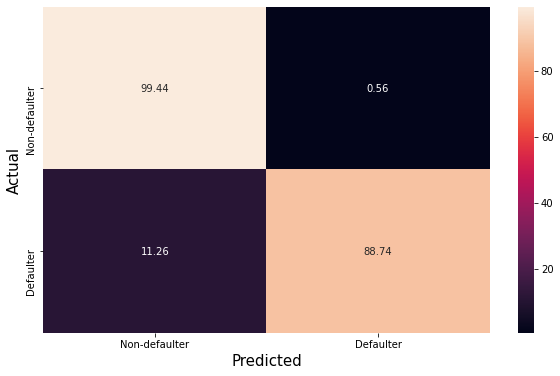

In [179]:
plot_confusion_matrix(test_targets, y_class_avg, 'CM_base_TF')

- The model has imbalanced ratio between FN (1%) and FP (~11%) which would predict more actual loan defaulter as non-defaulter
- Desirable is to get relatively small FP and FN in a balanced proportion

### Effect of Additional Features on Model Performance
In this section, we will explore the effect of additional features added manually during EDA stages on model performance. 


#### Data Set

In [181]:
# Columns to keep
columns_to_keep = list(list(df_one_hot_code)+list(df_scaled_num.columns))
columns_to_keep = list(set(columns_to_keep)-set(['TARGET']))

# Train set
train_inputs_add = train_df[columns_to_keep]
train_targets_add = train_df['TARGET']

# Validation set
validation_inputs_add = validation_df[columns_to_keep]
validation_targets_add = validation_df['TARGET']

# Test set
test_inputs_add = test_df[columns_to_keep]
test_targets_add = test_df['TARGET']

In [182]:
train_inputs_add.head(3)

FLAG_DOCUMENT_5_scaled  FLAG_DOCUMENT_15_scaled  \
0                       0                        0   
1                       0                        0   
2                       0                        0   

   NAME_FAMILY_STATUS_Civil marriage  CNT_FAM_MEMBERS_scaled  \
0                                  0                       0   
1                                  0                       0   
2                                  0                       0   

   WALLSMATERIAL_MODE_Monolithic  FLAG_DOCUMENT_14_scaled  \
0                              0                        0   
1                              0                        0   
2                              0                        0   

   NAME_HOUSING_TYPE_Municipal apartment  EMPLOYED_OVER_AGE_scaled  \
0                                      0                 -0.243767   
1                                      0                 -0.659135   
2                                      0                 -0.951884   

   REG_REGION_NOT_WORK_REGION_scaled  FLAG_DOCUMENT_6_scaled  ...  \
0                                  0                       0  ...   
1                                  0                       0  ...   
2                                  0                       1  ...   

   NAME_INCOME_TYPE_Maternity leave  NAME_FAMILY_STATUS_Married  \
0                                 0                           1   
1                                 0                           0   
2                                 0                           1   

   AMT_REQ_CREDIT_BUREAU_WEEK_scaled  NAME_FAMILY_STATUS_Widow  \
0                          -0.155837                         0   
1                          -0.155837                         0   
2                          -0.155837                         0   

   CNT_CHILDREN_ANOM_scaled  FLAG_MOBIL_scaled  BUILD_OVER_AGE_scaled  \
0                         0                  1               0.855274   
1                         0                  1               1.051062   
2                         0                  1              -0.473017   

   NONLIVINGAPARTMENTS_AVG_scaled  ANNUNITY_OVER_INCOME_scaled  \
0                    2.156121e-14                    -0.001897   
1                    2.156121e-14                    -0.734726   
2                    2.156121e-14                    -0.221305   

   WALLSMATERIAL_MODE_Wooden  
0                          0  
1                          0  
2                          0  

[3 rows x 144 columns]

#### Model Performance without Additional Features

In [183]:
accuracy, auc_roc, fpr, tpr, y_class_avg, y_prob_base = model_metrics(train_inputs_add, train_targets_add, validation_inputs_add, validation_targets_add, test_inputs_add, test_targets_add)

Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 2s - loss: 0.2604 - accuracy: 0.8943 - val_loss: 0.1918 - val_accuracy: 0.9339
Epoch 2/100
39720/39720 - 1s - loss: 0.1810 - accuracy: 0.9365 - val_loss: 0.2046 - val_accuracy: 0.9223
Epoch 3/100
39720/39720 - 1s - loss: 0.1715 - accuracy: 0.9404 - val_loss: 0.1808 - val_accuracy: 0.9380
Epoch 4/100
39720/39720 - 1s - loss: 0.1649 - accuracy: 0.9442 - val_loss: 0.1796 - val_accuracy: 0.9404
Epoch 5/100
39720/39720 - 1s - loss: 0.1596 - accuracy: 0.9450 - val_loss: 0.1807 - val_accuracy: 0.9382
Epoch 6/100
39720/39720 - 1s - loss: 0.1559 - accuracy: 0.9466 - val_loss: 0.1783 - val_accuracy: 0.9408
Epoch 7/100
39720/39720 - 1s - loss: 0.1533 - accuracy: 0.9472 - val_loss: 0.1798 - val_accuracy: 0.9388
Epoch 8/100
39720/39720 - 1s - loss: 0.1499 - accuracy: 0.9476 - val_loss: 0.1834 - val_accuracy: 0.9364
4965/1 [=======================================================================================================

Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 2s - loss: 0.2549 - accuracy: 0.8995 - val_loss: 0.1952 - val_accuracy: 0.9313
Epoch 2/100
39720/39720 - 1s - loss: 0.1839 - accuracy: 0.9359 - val_loss: 0.2081 - val_accuracy: 0.9200
Epoch 3/100
39720/39720 - 1s - loss: 0.1754 - accuracy: 0.9391 - val_loss: 0.1867 - val_accuracy: 0.9351
Epoch 4/100
39720/39720 - 1s - loss: 0.1703 - accuracy: 0.9421 - val_loss: 0.1865 - val_accuracy: 0.9380
Epoch 5/100
39720/39720 - 1s - loss: 0.1647 - accuracy: 0.9437 - val_loss: 0.1884 - val_accuracy: 0.9364
Epoch 6/100
39720/39720 - 1s - loss: 0.1606 - accuracy: 0.9454 - val_loss: 0.1848 - val_accuracy: 0.9398
Epoch 7/100
39720/39720 - 1s - loss: 0.1572 - accuracy: 0.9456 - val_loss: 0.1829 - val_accuracy: 0.9368
Epoch 8/100
39720/39720 - 1s - loss: 0.1528 - accuracy: 0.9473 - val_loss: 0.1906 - val_accuracy: 0.9341
Epoch 9/100
39720/39720 - 1s - loss: 0.1493 - accuracy: 0.9472 - val_loss: 0.1834 - val_accuracy: 0.9384
4965/1

Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 1s - loss: 0.2521 - accuracy: 0.9003 - val_loss: 0.1933 - val_accuracy: 0.9327
Epoch 2/100
39720/39720 - 1s - loss: 0.1823 - accuracy: 0.9363 - val_loss: 0.2065 - val_accuracy: 0.9235
Epoch 3/100
39720/39720 - 1s - loss: 0.1746 - accuracy: 0.9394 - val_loss: 0.1875 - val_accuracy: 0.9347
Epoch 4/100
39720/39720 - 1s - loss: 0.1693 - accuracy: 0.9421 - val_loss: 0.1849 - val_accuracy: 0.9374
Epoch 5/100
39720/39720 - 1s - loss: 0.1647 - accuracy: 0.9431 - val_loss: 0.1867 - val_accuracy: 0.9353
Epoch 6/100
39720/39720 - 1s - loss: 0.1620 - accuracy: 0.9443 - val_loss: 0.1851 - val_accuracy: 0.9382
4965/1 [=========================================================================================================================================================================================================================================================================================================================

Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 2s - loss: 0.2740 - accuracy: 0.8872 - val_loss: 0.1914 - val_accuracy: 0.9337
Epoch 2/100
39720/39720 - 1s - loss: 0.1830 - accuracy: 0.9352 - val_loss: 0.2094 - val_accuracy: 0.9190
Epoch 3/100
39720/39720 - 1s - loss: 0.1752 - accuracy: 0.9395 - val_loss: 0.1869 - val_accuracy: 0.9351
Epoch 4/100
39720/39720 - 1s - loss: 0.1699 - accuracy: 0.9421 - val_loss: 0.1861 - val_accuracy: 0.9370
Epoch 5/100
39720/39720 - 1s - loss: 0.1656 - accuracy: 0.9432 - val_loss: 0.1896 - val_accuracy: 0.9360
Epoch 6/100
39720/39720 - 1s - loss: 0.1619 - accuracy: 0.9452 - val_loss: 0.1862 - val_accuracy: 0.9382
4965/1 [=========================================================================================================================================================================================================================================================================================================================

Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 2s - loss: 0.2540 - accuracy: 0.9001 - val_loss: 0.1940 - val_accuracy: 0.9323
Epoch 2/100
39720/39720 - 1s - loss: 0.1832 - accuracy: 0.9362 - val_loss: 0.2028 - val_accuracy: 0.9245
Epoch 3/100
39720/39720 - 1s - loss: 0.1758 - accuracy: 0.9395 - val_loss: 0.1857 - val_accuracy: 0.9355
Epoch 4/100
39720/39720 - 1s - loss: 0.1707 - accuracy: 0.9426 - val_loss: 0.1842 - val_accuracy: 0.9392
Epoch 5/100
39720/39720 - 1s - loss: 0.1662 - accuracy: 0.9430 - val_loss: 0.1858 - val_accuracy: 0.9368
Epoch 6/100
39720/39720 - 1s - loss: 0.1623 - accuracy: 0.9450 - val_loss: 0.1820 - val_accuracy: 0.9420
Epoch 7/100
39720/39720 - 1s - loss: 0.1589 - accuracy: 0.9458 - val_loss: 0.1843 - val_accuracy: 0.9380
Epoch 8/100
39720/39720 - 1s - loss: 0.1543 - accuracy: 0.9466 - val_loss: 0.1915 - val_accuracy: 0.9351
4965/1 [=======================================================================================================

Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 2s - loss: 0.2494 - accuracy: 0.9025 - val_loss: 0.1906 - val_accuracy: 0.9364
Epoch 2/100
39720/39720 - 1s - loss: 0.1837 - accuracy: 0.9359 - val_loss: 0.2028 - val_accuracy: 0.9239
Epoch 3/100
39720/39720 - 1s - loss: 0.1761 - accuracy: 0.9389 - val_loss: 0.1832 - val_accuracy: 0.9376
Epoch 4/100
39720/39720 - 1s - loss: 0.1710 - accuracy: 0.9416 - val_loss: 0.1819 - val_accuracy: 0.9400
Epoch 5/100
39720/39720 - 1s - loss: 0.1663 - accuracy: 0.9420 - val_loss: 0.1830 - val_accuracy: 0.9384
Epoch 6/100
39720/39720 - 1s - loss: 0.1620 - accuracy: 0.9445 - val_loss: 0.1810 - val_accuracy: 0.9420
Epoch 7/100
39720/39720 - 1s - loss: 0.1578 - accuracy: 0.9448 - val_loss: 0.1785 - val_accuracy: 0.9394
Epoch 8/100
39720/39720 - 1s - loss: 0.1540 - accuracy: 0.9469 - val_loss: 0.1848 - val_accuracy: 0.9366
Epoch 9/100
39720/39720 - 1s - loss: 0.1500 - accuracy: 0.9470 - val_loss: 0.1742 - val_accuracy: 0.9420
Epoch 

Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 2s - loss: 0.2614 - accuracy: 0.8941 - val_loss: 0.1946 - val_accuracy: 0.9337
Epoch 2/100
39720/39720 - 1s - loss: 0.1842 - accuracy: 0.9352 - val_loss: 0.2098 - val_accuracy: 0.9208
Epoch 3/100
39720/39720 - 1s - loss: 0.1762 - accuracy: 0.9395 - val_loss: 0.1841 - val_accuracy: 0.9362
Epoch 4/100
39720/39720 - 1s - loss: 0.1712 - accuracy: 0.9412 - val_loss: 0.1813 - val_accuracy: 0.9392
Epoch 5/100
39720/39720 - 1s - loss: 0.1660 - accuracy: 0.9426 - val_loss: 0.1850 - val_accuracy: 0.9370
Epoch 6/100
39720/39720 - 1s - loss: 0.1633 - accuracy: 0.9443 - val_loss: 0.1811 - val_accuracy: 0.9386
Epoch 7/100
39720/39720 - 1s - loss: 0.1584 - accuracy: 0.9458 - val_loss: 0.1817 - val_accuracy: 0.9386
Epoch 8/100
39720/39720 - 1s - loss: 0.1550 - accuracy: 0.9463 - val_loss: 0.1883 - val_accuracy: 0.9343
4965/1 [=======================================================================================================

Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 2s - loss: 0.2550 - accuracy: 0.8980 - val_loss: 0.1937 - val_accuracy: 0.9327
Epoch 2/100
39720/39720 - 1s - loss: 0.1827 - accuracy: 0.9358 - val_loss: 0.2117 - val_accuracy: 0.9170
Epoch 3/100
39720/39720 - 1s - loss: 0.1745 - accuracy: 0.9391 - val_loss: 0.1842 - val_accuracy: 0.9349
Epoch 4/100
39720/39720 - 1s - loss: 0.1687 - accuracy: 0.9425 - val_loss: 0.1841 - val_accuracy: 0.9390
Epoch 5/100
39720/39720 - 1s - loss: 0.1634 - accuracy: 0.9431 - val_loss: 0.1847 - val_accuracy: 0.9382
Epoch 6/100
39720/39720 - 1s - loss: 0.1588 - accuracy: 0.9453 - val_loss: 0.1827 - val_accuracy: 0.9404
Epoch 7/100
39720/39720 - 1s - loss: 0.1545 - accuracy: 0.9458 - val_loss: 0.1847 - val_accuracy: 0.9386
Epoch 8/100
39720/39720 - 1s - loss: 0.1501 - accuracy: 0.9478 - val_loss: 0.1961 - val_accuracy: 0.9335
4965/1 [=======================================================================================================

Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 2s - loss: 0.2494 - accuracy: 0.9030 - val_loss: 0.1949 - val_accuracy: 0.9329
Epoch 2/100
39720/39720 - 1s - loss: 0.1823 - accuracy: 0.9358 - val_loss: 0.2036 - val_accuracy: 0.9217
Epoch 3/100
39720/39720 - 1s - loss: 0.1740 - accuracy: 0.9398 - val_loss: 0.1853 - val_accuracy: 0.9362
Epoch 4/100
39720/39720 - 1s - loss: 0.1681 - accuracy: 0.9427 - val_loss: 0.1861 - val_accuracy: 0.9376
Epoch 5/100
39720/39720 - 1s - loss: 0.1635 - accuracy: 0.9430 - val_loss: 0.1878 - val_accuracy: 0.9349
4965/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 2s - loss: 0.2508 - accuracy: 0.9015 - val_loss: 0.1922 - val_accuracy: 0.9358
Epoch 2/100
39720/39720 - 1s - loss: 0.1828 - accuracy: 0.9359 - val_loss: 0.2114 - val_accuracy: 0.9166
Epoch 3/100
39720/39720 - 1s - loss: 0.1747 - accuracy: 0.9388 - val_loss: 0.1848 - val_accuracy: 0.9374
Epoch 4/100
39720/39720 - 1s - loss: 0.1687 - accuracy: 0.9421 - val_loss: 0.1834 - val_accuracy: 0.9382
Epoch 5/100
39720/39720 - 1s - loss: 0.1640 - accuracy: 0.9428 - val_loss: 0.1841 - val_accuracy: 0.9382
Epoch 6/100
39720/39720 - 1s - loss: 0.1601 - accuracy: 0.9444 - val_loss: 0.1837 - val_accuracy: 0.9416
4965/1 [=========================================================================================================================================================================================================================================================================================================================

In [185]:
# accuracy, AUC
print('Test accuracy is: {:.2f}%'.format(100*accuracy))
print('AUC-ROC value is: {:.4f}'.format(auc_roc))

Test accuracy is: 93.77%
AUC-ROC value is: 0.9715


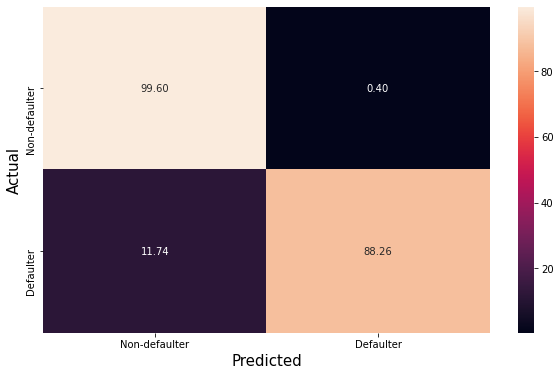

In [186]:
plot_confusion_matrix(test_targets, y_class_avg, 'CM_base_no_add_feature_TF')

- Added features did not improve performance significantly (only by 0.05)
- We will not include additional features for future analysis

### Dataset without Non-standardized Variables
We will include non-scaled features instead of scaled one to see the effect on model performances

In [187]:
# Columns to keep
columns_to_keep = list(df_one_hot_code.columns)+list(df_num.columns)
columns_to_keep = list(set(columns_to_keep)-set(['TARGET']))

# Train set
train_inputs_non = train_df[columns_to_keep]
train_targets_non = train_df['TARGET']

# Validation set
validation_inputs_non = validation_df[columns_to_keep]
validation_targets_non = validation_df['TARGET']

# Test set
test_inputs_non = test_df[columns_to_keep]
test_targets_non = test_df['TARGET']

In [188]:
accuracy_non, auc_roc_non, fpr_non, tpr_non, y_class_non, y_prob_non = model_metrics(train_inputs_non, train_targets_non, validation_inputs_non, validation_targets_non, test_inputs_non, test_targets_non)

Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 1s - loss: 649.4259 - accuracy: 0.7169 - val_loss: 337.5961 - val_accuracy: 0.7847
Epoch 2/100
39720/39720 - 1s - loss: 444.2848 - accuracy: 0.7158 - val_loss: 598.5452 - val_accuracy: 0.5132
Epoch 3/100
39720/39720 - 1s - loss: 181.9986 - accuracy: 0.7188 - val_loss: 475.7035 - val_accuracy: 0.6089
4965/1 [========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 2s - loss: 820.3404 - accuracy: 0.7055 - val_loss: 437.7948 - val_accuracy: 0.5351
Epoch 2/100
39720/39720 - 1s - loss: 285.9599 - accuracy: 0.7181 - val_loss: 169.7201 - val_accuracy: 0.7782
Epoch 3/100
39720/39720 - 1s - loss: 248.5273 - accuracy: 0.7172 - val_loss: 173.8799 - val_accuracy: 0.6477
Epoch 4/100
39720/39720 - 1s - loss: 190.5995 - accuracy: 0.7265 - val_loss: 290.7990 - val_accuracy: 0.7509
4965/1 [===========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 1s - loss: 761.0860 - accuracy: 0.7094 - val_loss: 158.7059 - val_accuracy: 0.6642
Epoch 2/100
39720/39720 - 1s - loss: 297.2901 - accuracy: 0.7159 - val_loss: 128.4872 - val_accuracy: 0.7261
Epoch 3/100
39720/39720 - 1s - loss: 150.7129 - accuracy: 0.7203 - val_loss: 97.0648 - val_accuracy: 0.7341
Epoch 4/100
39720/39720 - 1s - loss: 122.2879 - accuracy: 0.7272 - val_loss: 99.5496 - val_accuracy: 0.7857
Epoch 5/100
39720/39720 - 1s - loss: 106.8574 - accuracy: 0.7343 - val_loss: 61.7564 - val_accuracy: 0.7742
Epoch 6/100
39720/39720 - 1s - loss: 107.2184 - accuracy: 0.7329 - val_loss: 151.6141 - val_accuracy: 0.7811
Epoch 7/100
39720/39720 - 1s - loss: 101.7331 - accuracy: 0.7378 - val_loss: 103.7337 - val_accuracy: 0.7100
4965/1 [=======================================================================================================================================================================================

Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 1s - loss: 795.3851 - accuracy: 0.7081 - val_loss: 249.9920 - val_accuracy: 0.6226
Epoch 2/100
39720/39720 - 1s - loss: 172.9813 - accuracy: 0.7162 - val_loss: 340.6942 - val_accuracy: 0.5654
Epoch 3/100
39720/39720 - 1s - loss: 149.5917 - accuracy: 0.7227 - val_loss: 332.4980 - val_accuracy: 0.5976
4965/1 [========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 2s - loss: 329.1266 - accuracy: 0.7168 - val_loss: 107.9852 - val_accuracy: 0.7879
Epoch 2/100
39720/39720 - 1s - loss: 314.2197 - accuracy: 0.7099 - val_loss: 136.5756 - val_accuracy: 0.7698
Epoch 3/100
39720/39720 - 1s - loss: 150.3140 - accuracy: 0.7230 - val_loss: 212.7979 - val_accuracy: 0.7170
4965/1 [========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 2s - loss: 477.4584 - accuracy: 0.7067 - val_loss: 467.3829 - val_accuracy: 0.5692
Epoch 2/100
39720/39720 - 1s - loss: 325.2067 - accuracy: 0.7150 - val_loss: 1016.2798 - val_accuracy: 0.5249
Epoch 3/100
39720/39720 - 1s - loss: 228.8631 - accuracy: 0.7203 - val_loss: 172.4364 - val_accuracy: 0.7496
Epoch 4/100
39720/39720 - 1s - loss: 268.7121 - accuracy: 0.7280 - val_loss: 146.7194 - val_accuracy: 0.7505
Epoch 5/100
39720/39720 - 1s - loss: 150.7542 - accuracy: 0.7347 - val_loss: 191.4185 - val_accuracy: 0.7782
Epoch 6/100
39720/39720 - 1s - loss: 154.6216 - accuracy: 0.7362 - val_loss: 71.8569 - val_accuracy: 0.7251
Epoch 7/100
39720/39720 - 1s - loss: 130.1431 - accuracy: 0.7355 - val_loss: 185.0302 - val_accuracy: 0.6439
Epoch 8/100
39720/39720 - 1s - loss: 122.2207 - accuracy: 0.7431 - val_loss: 71.5071 - val_accuracy: 0.7519
Epoch 9/100
39720/39720 - 1s - loss: 124.0194 - accuracy: 0.7441 - val_loss: 89.

Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 2s - loss: 952.6553 - accuracy: 0.7135 - val_loss: 108.3520 - val_accuracy: 0.7174
Epoch 2/100
39720/39720 - 1s - loss: 210.1652 - accuracy: 0.7176 - val_loss: 775.8555 - val_accuracy: 0.5176
Epoch 3/100
39720/39720 - 1s - loss: 205.4453 - accuracy: 0.7199 - val_loss: 140.5104 - val_accuracy: 0.7364
4965/1 [========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 2s - loss: 875.0327 - accuracy: 0.7162 - val_loss: 115.9373 - val_accuracy: 0.6912
Epoch 2/100
39720/39720 - 1s - loss: 159.9010 - accuracy: 0.7187 - val_loss: 74.4774 - val_accuracy: 0.7174
Epoch 3/100
39720/39720 - 1s - loss: 385.1971 - accuracy: 0.7207 - val_loss: 100.3667 - val_accuracy: 0.7887
Epoch 4/100
39720/39720 - 1s - loss: 166.2201 - accuracy: 0.7268 - val_loss: 93.9060 - val_accuracy: 0.7889
4965/1 [=============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 2s - loss: 751.9754 - accuracy: 0.7100 - val_loss: 227.7013 - val_accuracy: 0.6753
Epoch 2/100
39720/39720 - 1s - loss: 219.3180 - accuracy: 0.7164 - val_loss: 176.6348 - val_accuracy: 0.7509
Epoch 3/100
39720/39720 - 1s - loss: 188.3437 - accuracy: 0.7181 - val_loss: 216.0958 - val_accuracy: 0.7194
Epoch 4/100
39720/39720 - 1s - loss: 360.0763 - accuracy: 0.7199 - val_loss: 168.1255 - val_accuracy: 0.6203
Epoch 5/100
39720/39720 - 1s - loss: 156.5238 - accuracy: 0.7283 - val_loss: 211.5633 - val_accuracy: 0.7515
Epoch 6/100
39720/39720 - 1s - loss: 167.9342 - accuracy: 0.7296 - val_loss: 65.9591 - val_accuracy: 0.7885
Epoch 7/100
39720/39720 - 1s - loss: 125.2625 - accuracy: 0.7319 - val_loss: 107.6113 - val_accuracy: 0.6618
Epoch 8/100
39720/39720 - 1s - loss: 150.0603 - accuracy: 0.7333 - val_loss: 78.8633 - val_accuracy: 0.7539
4965/1 [=========================================================================

Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 2s - loss: 1325.3249 - accuracy: 0.7067 - val_loss: 293.1594 - val_accuracy: 0.7895
Epoch 2/100
39720/39720 - 1s - loss: 294.8047 - accuracy: 0.7164 - val_loss: 325.5564 - val_accuracy: 0.6238
Epoch 3/100
39720/39720 - 1s - loss: 181.6419 - accuracy: 0.7193 - val_loss: 409.6063 - val_accuracy: 0.5442
4965/1 [=======================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [189]:
# accuracy, AUC
print('Test accuracy is: {:.2f}%'.format(100*accuracy_non))
print('AUC-ROC value is: {:.4f}'.format(auc_roc_non))

Test accuracy is: 69.18%
AUC-ROC value is: 0.6989


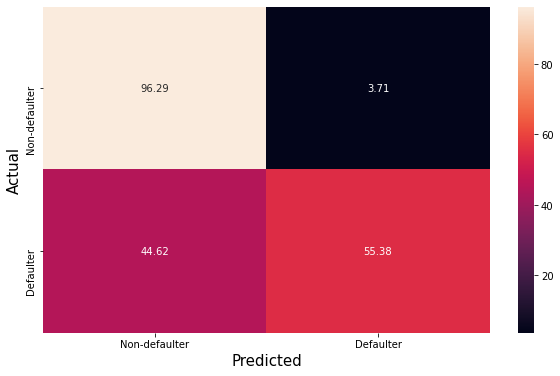

In [295]:
plot_confusion_matrix(test_targets, y_class_non, 'CM_base_non_scaled_TF')

- Non standardized dataset worsened model performance
- We will apply one-hot encoded and standardized variables for subsequent analysis

## 4.3 Hyperparameter Optimization for Deep Learning Model
Hyperparameters are:
- Number of hidden units (width)
- Number of hidden layers (height)
- Combinations of width and height
- Activation function (Relu, tanh, leaky Relu, sigmoid)
- Batch size (in a range between 1=SGD and 10,000)
- Learning rates (high at beginning low at end)
- Dropout

#### Data Preparation
Dataframe with one-hot-coded categorical columns and scaled numerical columns

In [41]:
# Columns to keep
columns_to_keep = list(list(df_one_hot_code)+list(df_scaled_num.columns))
columns_to_keep = list(set(columns_to_keep)-set(['TARGET']))

# Train set
train_inputs_tf_hyp = train_df[columns_to_keep]
train_targets_tf_hyp = train_df['TARGET']

# Validation set
validation_inputs_tf_hyp = validation_df[columns_to_keep]
validation_targets_tf_hyp = validation_df['TARGET']

# Test set
test_inputs_tf_hyp = test_df[columns_to_keep]
test_targets_tf_hyp = test_df['TARGET']

#### Width
Lets see the model performance at hidden layer size range from 5 to 300 in increament of 25
As the model will produce different results with same parameters every time run. We will run 10 times for a particular parameters set and take the average metrics.

In [31]:
# Define a baseline model to iterate over parameters---[width of the model]

def tf_model_train_width(train_inputs, train_targets, 
                        validation_inputs, validation_targets, 
                        test_inputs, test_targets, width):
    '''Function to train model based on input training data'''
    # Input/output layers size
    input_size = train_inputs.shape[0]
    output_size = 2
    
    # Hidden layer size
    hidden_layer_size = width
    
    # Model structure
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 1st hidden layer
        tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 2nd hidden layer
        tf.keras.layers.Dense(output_size, activation='softmax') # 'softmax' activation is suitable for classifier
    ])
    
    # Optimizer, loss function and metrics
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    ### Training
    # Batch size
    batch_size = 100
    # Number of training epochs
    max_epochs = 100
    
    # Early stopping: Allow for 2 instances of training after minimum loss point reached for for train/validation loss
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)
    
    # run the model 10 times and take average metrics
    auc_avg = []
    for i in range(10):
        # fit the model
        model.fit(train_inputs.values, # train inputs
              train_targets.values, # train targets
              batch_size=batch_size, # batch size
              epochs=max_epochs, # number of iteration the training will run, unless early stopping kicks in
              callbacks=[early_stopping], # early stopping
              validation_data=(validation_inputs.values, validation_targets.values), # validation data
              verbose = 2 # print minimum information during training
             )  
        # metrics
        y_prob = model.predict(test_inputs.values)
        # predicted class
        y_pred = y_prob.argmax(axis=-1)
        # calculate fpr, tpr
        fpr, tpr, thresholds = roc_curve(test_targets, y_prob[:,1], pos_label=1)
        # calculate AUC
        auc_roc = auc(fpr, tpr)
        auc_avg.append(auc_roc)
    
    return np.mean(auc_avg)

In [32]:
# Run 'width' 5 to 300 to see which yields best AUC score 

width_r = range(5, 300, 25)
auc_width = []
for width in width_r:
    auc_temp = tf_model_train_width(train_inputs_tf_hyp, train_targets_tf_hyp, 
                        validation_inputs_tf_hyp, validation_targets_tf_hyp, 
                        test_inputs_tf_hyp, test_targets_tf_hyp, width)
    auc_width.append(auc_temp)
    

Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 2s - loss: 0.3533 - accuracy: 0.8426 - val_loss: 0.2180 - val_accuracy: 0.9231
Epoch 2/100
39720/39720 - 1s - loss: 0.1944 - accuracy: 0.9315 - val_loss: 0.1919 - val_accuracy: 0.9309
Epoch 3/100
39720/39720 - 1s - loss: 0.1810 - accuracy: 0.9383 - val_loss: 0.1877 - val_accuracy: 0.9351
Epoch 4/100
39720/39720 - 1s - loss: 0.1750 - accuracy: 0.9413 - val_loss: 0.1860 - val_accuracy: 0.9392
Epoch 5/100
39720/39720 - 1s - loss: 0.1726 - accuracy: 0.9420 - val_loss: 0.1838 - val_accuracy: 0.9384
Epoch 6/100
39720/39720 - 1s - loss: 0.1691 - accuracy: 0.9436 - val_loss: 0.1755 - val_accuracy: 0.9430
Epoch 7/100
39720/39720 - 1s - loss: 0.1657 - accuracy: 0.9443 - val_loss: 0.1763 - val_accuracy: 0.9412
Epoch 8/100
39720/39720 - 1s - loss: 0.1644 - accuracy: 0.9447 - val_loss: 0.1735 - val_accuracy: 0.9432
Epoch 9/100
39720/39720 - 1s - loss: 0.1616 - accuracy: 0.9457 - val_loss: 0.1727 - val_accuracy: 0.9460
Epoch 

Epoch 7/100
39720/39720 - 1s - loss: 0.1481 - accuracy: 0.9488 - val_loss: 0.1742 - val_accuracy: 0.9398
Epoch 8/100
39720/39720 - 1s - loss: 0.1463 - accuracy: 0.9499 - val_loss: 0.1748 - val_accuracy: 0.9384
Epoch 9/100
39720/39720 - 1s - loss: 0.1431 - accuracy: 0.9494 - val_loss: 0.1731 - val_accuracy: 0.9426
Epoch 10/100
39720/39720 - 1s - loss: 0.1416 - accuracy: 0.9511 - val_loss: 0.1721 - val_accuracy: 0.9394
Epoch 11/100
39720/39720 - 1s - loss: 0.1399 - accuracy: 0.9513 - val_loss: 0.1660 - val_accuracy: 0.9442
Epoch 12/100
39720/39720 - 1s - loss: 0.1372 - accuracy: 0.9519 - val_loss: 0.1723 - val_accuracy: 0.9408
Epoch 13/100
39720/39720 - 1s - loss: 0.1360 - accuracy: 0.9516 - val_loss: 0.1791 - val_accuracy: 0.9345
Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 1s - loss: 0.1346 - accuracy: 0.9525 - val_loss: 0.1732 - val_accuracy: 0.9380
Epoch 2/100
39720/39720 - 1s - loss: 0.1328 - accuracy: 0.9533 - val_loss: 0.1794 - val_accuracy: 0.9366
Ep

Epoch 3/100
39720/39720 - 1s - loss: 0.0993 - accuracy: 0.9630 - val_loss: 0.2371 - val_accuracy: 0.9198
Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 1s - loss: 0.1006 - accuracy: 0.9622 - val_loss: 0.2262 - val_accuracy: 0.9287
Epoch 2/100
39720/39720 - 1s - loss: 0.0928 - accuracy: 0.9659 - val_loss: 0.2496 - val_accuracy: 0.9196
Epoch 3/100
39720/39720 - 1s - loss: 0.0916 - accuracy: 0.9663 - val_loss: 0.2444 - val_accuracy: 0.9178
Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 1s - loss: 0.0892 - accuracy: 0.9674 - val_loss: 0.2399 - val_accuracy: 0.9275
Epoch 2/100
39720/39720 - 1s - loss: 0.0885 - accuracy: 0.9676 - val_loss: 0.2628 - val_accuracy: 0.9194
Epoch 3/100
39720/39720 - 1s - loss: 0.0875 - accuracy: 0.9675 - val_loss: 0.2631 - val_accuracy: 0.9104
Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 1s - loss: 0.0847 - accuracy: 0.9685 - val_loss: 0.2510 - val_accuracy: 0.9267
Epoch 2/100
3

Epoch 3/100
39720/39720 - 1s - loss: 0.0633 - accuracy: 0.9769 - val_loss: 0.3228 - val_accuracy: 0.9114
Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 1s - loss: 0.0598 - accuracy: 0.9786 - val_loss: 0.3209 - val_accuracy: 0.9156
Epoch 2/100
39720/39720 - 1s - loss: 0.0549 - accuracy: 0.9798 - val_loss: 0.3424 - val_accuracy: 0.9158
Epoch 3/100
39720/39720 - 1s - loss: 0.0513 - accuracy: 0.9813 - val_loss: 0.3655 - val_accuracy: 0.9031
Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 1s - loss: 0.0488 - accuracy: 0.9820 - val_loss: 0.3516 - val_accuracy: 0.9166
Epoch 2/100
39720/39720 - 1s - loss: 0.0461 - accuracy: 0.9835 - val_loss: 0.3896 - val_accuracy: 0.9084
Epoch 3/100
39720/39720 - 1s - loss: 0.0407 - accuracy: 0.9855 - val_loss: 0.3812 - val_accuracy: 0.9092
Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 1s - loss: 0.0380 - accuracy: 0.9867 - val_loss: 0.3816 - val_accuracy: 0.9126
Epoch 2/100
3

Epoch 3/100
39720/39720 - 2s - loss: 0.0328 - accuracy: 0.9892 - val_loss: 0.3890 - val_accuracy: 0.9156
Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 1s - loss: 0.0260 - accuracy: 0.9915 - val_loss: 0.3961 - val_accuracy: 0.9152
Epoch 2/100
39720/39720 - 1s - loss: 0.0285 - accuracy: 0.9912 - val_loss: 0.4269 - val_accuracy: 0.9146
Epoch 3/100
39720/39720 - 1s - loss: 0.0255 - accuracy: 0.9915 - val_loss: 0.4070 - val_accuracy: 0.9160
Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 1s - loss: 0.0280 - accuracy: 0.9909 - val_loss: 0.4293 - val_accuracy: 0.9114
Epoch 2/100
39720/39720 - 1s - loss: 0.0185 - accuracy: 0.9944 - val_loss: 0.4637 - val_accuracy: 0.9184
Epoch 3/100
39720/39720 - 1s - loss: 0.0196 - accuracy: 0.9943 - val_loss: 0.4592 - val_accuracy: 0.9110
Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 2s - loss: 0.0317 - accuracy: 0.9893 - val_loss: 0.4342 - val_accuracy: 0.9057
Epoch 2/100
3

Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 1s - loss: 0.0189 - accuracy: 0.9938 - val_loss: 0.4509 - val_accuracy: 0.9174
Epoch 2/100
39720/39720 - 1s - loss: 0.0263 - accuracy: 0.9915 - val_loss: 0.5244 - val_accuracy: 0.9160
Epoch 3/100
39720/39720 - 1s - loss: 0.0256 - accuracy: 0.9919 - val_loss: 0.4827 - val_accuracy: 0.9118
Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 2s - loss: 0.0232 - accuracy: 0.9931 - val_loss: 0.4411 - val_accuracy: 0.9204
Epoch 2/100
39720/39720 - 1s - loss: 0.0201 - accuracy: 0.9940 - val_loss: 0.4867 - val_accuracy: 0.9144
Epoch 3/100
39720/39720 - 1s - loss: 0.0232 - accuracy: 0.9926 - val_loss: 0.4852 - val_accuracy: 0.9112
Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 1s - loss: 0.0324 - accuracy: 0.9949 - val_loss: 0.5084 - val_accuracy: 0.9251
Epoch 2/100
39720/39720 - 1s - loss: 0.0113 - accuracy: 0.9972 - val_loss: 0.5206 - val_accuracy: 0.9263
Epoch 3/100
3

Epoch 4/100
39720/39720 - 2s - loss: 0.0223 - accuracy: 0.9926 - val_loss: 0.5015 - val_accuracy: 0.9202
Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 2s - loss: 0.0242 - accuracy: 0.9919 - val_loss: 0.4993 - val_accuracy: 0.9152
Epoch 2/100
39720/39720 - 2s - loss: 0.0203 - accuracy: 0.9942 - val_loss: 0.4894 - val_accuracy: 0.9208
Epoch 3/100
39720/39720 - 2s - loss: 0.0104 - accuracy: 0.9972 - val_loss: 0.5772 - val_accuracy: 0.9116
Epoch 4/100
39720/39720 - 2s - loss: 0.0132 - accuracy: 0.9963 - val_loss: 0.5466 - val_accuracy: 0.9150
Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 2s - loss: 0.0185 - accuracy: 0.9943 - val_loss: 0.5898 - val_accuracy: 0.9215
Epoch 2/100
39720/39720 - 2s - loss: 0.0079 - accuracy: 0.9979 - val_loss: 0.5752 - val_accuracy: 0.9212
Epoch 3/100
39720/39720 - 2s - loss: 0.0155 - accuracy: 0.9949 - val_loss: 0.5872 - val_accuracy: 0.9057
Epoch 4/100
39720/39720 - 2s - loss: 0.0178 - accuracy: 0.9939

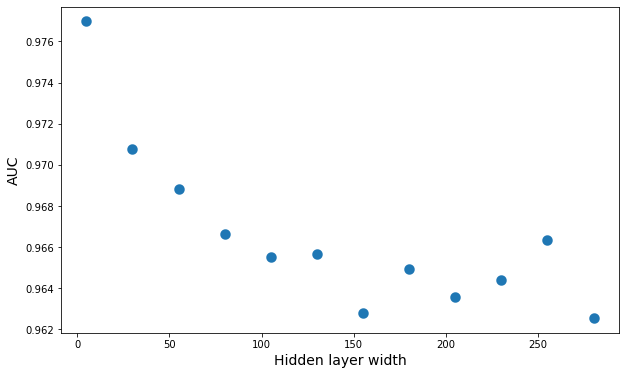

In [33]:
# Plot 'width' vs 'AUC' score 

width_df = pd.DataFrame(data= {'width': width_r, 'AUC':auc_width})
width_df.sort_values(by='AUC', ascending= False).plot(kind='scatter',x='width', y='AUC', linewidth=6, figsize=(10,6))
plt.xlabel('Hidden layer width', fontsize=14)
plt.ylabel('AUC', fontsize=14)
plt.savefig('figures/Model/'+'AUC_vs_width'+'.png')
plt.show()

In [34]:
# print width number for maximum AUC

maximum_auc_width = width_df.sort_values(by='AUC', ascending= False).iloc[0, :]
print('Maximum AUC is: {:.2f} for width number {}'.format(maximum_auc_width[1],maximum_auc_width[0])) 

Maximum AUC is: 0.98 for width number 5.0


- We see a decreasing trend of AUC with the increase of width
- It appears the significant information content are limited to first couple of dominant features signalled by low number of hidden layer width (5)
- For the subsequent analysis, a hidden layer width of 5 will be used

#### Depth
Lets extend the hidden layer depth upto 6 layers starting from 2
Train model for every set for 50 times and take the average of auc score

In [280]:
# Define a baseline model to iterate over parameters---[Depth of the model]
# run this function every time we add a layer

def tf_model_train_depth(train_inputs, train_targets, 
                        validation_inputs, validation_targets, 
                        test_inputs, test_targets):
    '''Function to train model based on input training data'''
    # Input/output layers size
    input_size = train_inputs.shape[0]
    output_size = 2
    
    # Hidden layer size
    hidden_layer_size = 5
    
    # Model structure
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 1st hidden layer
        tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 2nd hidden layer
        tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 3rd hidden layer
        tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 4th hidden layer
        tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 5th hidden layer
  
        
        tf.keras.layers.Dense(output_size, activation='softmax') # 'softmax' activation is suitable for classifier
    ])
    
    # Optimizer, loss function and metrics
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    ### Training
    # Batch size
    batch_size = 100
    # Number of training epochs
    max_epochs = 100
    
    # Early stopping: Allow for 2 instances of training after minimum loss point reached for for train/validation loss
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)
    
    
    # run the model 50 times and take average metrics
    auc_avg = []
    for i in range(50):
        # fit the model
        model.fit(train_inputs.values, # train inputs
              train_targets.values, # train targets
              batch_size=batch_size, # batch size
              epochs=max_epochs, # number of iteration the training will run, unless early stopping kicks in
              callbacks=[early_stopping], # early stopping
              validation_data=(validation_inputs.values, validation_targets.values), # validation data
              verbose = 2 # print minimum information during training
             )  
        # metrics
        y_prob = model.predict(test_inputs.values)
        # predicted class
        y_pred = y_prob.argmax(axis=-1)
        # calculate fpr, tpr
        fpr, tpr, thresholds = roc_curve(test_targets, y_prob[:,1], pos_label=1)
        # calculate AUC
        auc_roc = auc(fpr, tpr)
        auc_avg.append(auc_roc)
    
    
    return np.mean(auc_avg)

In [381]:
# Run 'depth' of 2 to 6 to see which yields best AUC score

auc_depth = tf_model_train_depth(train_inputs_tf_hyp, train_targets_tf_hyp, 
                        validation_inputs_tf_hyp, validation_targets_tf_hyp, 
                        test_inputs_tf_hyp, test_targets_tf_hyp)

Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 1s - loss: 0.4612 - accuracy: 0.8242 - val_loss: 0.2843 - val_accuracy: 0.9259
Epoch 2/100
39720/39720 - 1s - loss: 0.2262 - accuracy: 0.9350 - val_loss: 0.2130 - val_accuracy: 0.9319
Epoch 3/100
39720/39720 - 1s - loss: 0.1892 - accuracy: 0.9398 - val_loss: 0.1924 - val_accuracy: 0.9374
Epoch 4/100
39720/39720 - 1s - loss: 0.1782 - accuracy: 0.9423 - val_loss: 0.1870 - val_accuracy: 0.9404
Epoch 5/100
39720/39720 - 1s - loss: 0.1736 - accuracy: 0.9432 - val_loss: 0.1834 - val_accuracy: 0.9414
Epoch 6/100
39720/39720 - 1s - loss: 0.1703 - accuracy: 0.9451 - val_loss: 0.1802 - val_accuracy: 0.9436
Epoch 7/100
39720/39720 - 1s - loss: 0.1680 - accuracy: 0.9450 - val_loss: 0.1796 - val_accuracy: 0.9426
Epoch 8/100
39720/39720 - 1s - loss: 0.1664 - accuracy: 0.9453 - val_loss: 0.1800 - val_accuracy: 0.9418
Epoch 9/100
39720/39720 - 1s - loss: 0.1641 - accuracy: 0.9457 - val_loss: 0.1762 - val_accuracy: 0.9446
Epoch 

Epoch 3/100
39720/39720 - 1s - loss: 0.1435 - accuracy: 0.9522 - val_loss: 0.1574 - val_accuracy: 0.9462
Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 1s - loss: 0.1419 - accuracy: 0.9524 - val_loss: 0.1609 - val_accuracy: 0.9464
Epoch 2/100
39720/39720 - 1s - loss: 0.1415 - accuracy: 0.9527 - val_loss: 0.1587 - val_accuracy: 0.9488
Epoch 3/100
39720/39720 - 1s - loss: 0.1432 - accuracy: 0.9522 - val_loss: 0.1561 - val_accuracy: 0.9488
Epoch 4/100
39720/39720 - 1s - loss: 0.1411 - accuracy: 0.9530 - val_loss: 0.1576 - val_accuracy: 0.9474
Epoch 5/100
39720/39720 - 1s - loss: 0.1406 - accuracy: 0.9533 - val_loss: 0.1611 - val_accuracy: 0.9490
Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 1s - loss: 0.1420 - accuracy: 0.9527 - val_loss: 0.1595 - val_accuracy: 0.9474
Epoch 2/100
39720/39720 - 1s - loss: 0.1421 - accuracy: 0.9525 - val_loss: 0.1625 - val_accuracy: 0.9470
Epoch 3/100
39720/39720 - 1s - loss: 0.1427 - accuracy: 0.9528

Epoch 8/100
39720/39720 - 1s - loss: 0.1373 - accuracy: 0.9546 - val_loss: 0.1584 - val_accuracy: 0.9486
Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 1s - loss: 0.1371 - accuracy: 0.9544 - val_loss: 0.1586 - val_accuracy: 0.9492
Epoch 2/100
39720/39720 - 1s - loss: 0.1365 - accuracy: 0.9548 - val_loss: 0.1543 - val_accuracy: 0.9505
Epoch 3/100
39720/39720 - 1s - loss: 0.1365 - accuracy: 0.9549 - val_loss: 0.1573 - val_accuracy: 0.9515
Epoch 4/100
39720/39720 - 1s - loss: 0.1355 - accuracy: 0.9551 - val_loss: 0.1565 - val_accuracy: 0.9503
Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 1s - loss: 0.1363 - accuracy: 0.9548 - val_loss: 0.1561 - val_accuracy: 0.9498
Epoch 2/100
39720/39720 - 1s - loss: 0.1362 - accuracy: 0.9547 - val_loss: 0.1551 - val_accuracy: 0.9507
Epoch 3/100
39720/39720 - 1s - loss: 0.1368 - accuracy: 0.9551 - val_loss: 0.1553 - val_accuracy: 0.9519
Epoch 4/100
39720/39720 - 1s - loss: 0.1365 - accuracy: 0.9547

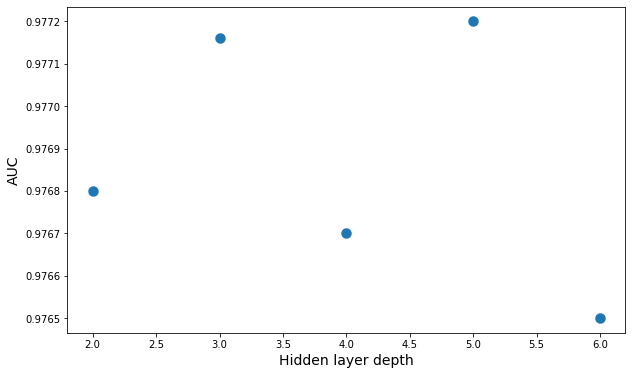

In [281]:
# Plot of 'depth' vs 'AUC' score

depth_df = pd.DataFrame(data = {'depth': [2, 3, 4, 5, 6], 'AUC': [.9768,.97716, .9767, .9772, .9765 ]})
depth_df.sort_values(by='AUC', ascending= False).plot(kind='scatter',x='depth', y='AUC', linewidth=6, figsize=(10,6))
plt.xlabel('Hidden layer depth', fontsize=14)
plt.ylabel('AUC', fontsize=14)
plt.savefig('figures/Model/'+'AUC_vs_depth'+'.png')
plt.show()

In [282]:
# print depth number for maximum AUC

maximum_auc_depth = depth_df.sort_values(by='AUC', ascending= False).iloc[0, :]
print('Maximum AUC is: {:.4f} for depth number {}'.format(maximum_auc_depth[1],maximum_auc_depth[0])) 

Maximum AUC is: 0.9772 for depth number 5.0


- A clear upward-downward trend was seen for the AUC vs number of depth layer plot
- The maximum AUC was found for 5 hidden layers

#### Width and Depth
Keeping the depth at 5 lets tune the width again to see if the performance improves for another width or remains the same.

In [192]:
# Define a baseline model to iterate over parameters---[Width and Depth]

def tf_model_train_wid_dep(train_inputs, train_targets, 
                        validation_inputs, validation_targets, 
                        test_inputs, test_targets, width):
    '''Function to train model based on input training data'''
    # Input/output layers size
    input_size = train_inputs.shape[0]
    output_size = 2
    
    # Hidden layer size
    hidden_layer_size = width
    
    # Model structure
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 1st hidden layer
        tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 2nd hidden layer
        tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 3rd hidden layer
        tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 4th hidden layer
        tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 5th hidden layer
  
        
        tf.keras.layers.Dense(output_size, activation='softmax') # 'softmax' activation is suitable for classifier
    ])
    
    # Optimizer, loss function and metrics
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    ### Training
    # Batch size
    batch_size = 100
    # Number of training epochs
    max_epochs = 100
    
    # Early stopping: Allow for 2 instances of training after minimum loss point reached for for train/validation loss
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)
    
    
    # run the model 10 times and take average metrics
    auc_avg = []
    for i in range(10):
        # fit the model
        model.fit(train_inputs.values, # train inputs
              train_targets.values, # train targets
              batch_size=batch_size, # batch size
              epochs=max_epochs, # number of iteration the training will run, unless early stopping kicks in
              callbacks=[early_stopping], # early stopping
              validation_data=(validation_inputs.values, validation_targets.values), # validation data
              verbose = 2 # print minimum information during training
             )  
        # metrics
        y_prob = model.predict(test_inputs.values)
        # predicted class
        y_pred = y_prob.argmax(axis=-1)
        # calculate fpr, tpr
        fpr, tpr, thresholds = roc_curve(test_targets, y_prob[:,1], pos_label=1)
        # calculate AUC
        auc_roc = auc(fpr, tpr)
        auc_avg.append(auc_roc)
    
    
    return np.mean(auc_avg)

In [193]:
# For a 'depth' of 5, run algorithm with 'width' 5 to 200 to see which one yields best AUC score

width_depth = range(5, 200, 20)
auc_wid_dep = []
for wid_dep in width_depth:
    auc_temp = tf_model_train_wid_dep(train_inputs_tf_hyp, train_targets_tf_hyp, 
                        validation_inputs_tf_hyp, validation_targets_tf_hyp, 
                        test_inputs_tf_hyp, test_targets_tf_hyp, wid_dep)
    auc_wid_dep.append(auc_temp)
    

Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 2s - loss: 0.3874 - accuracy: 0.8307 - val_loss: 0.1942 - val_accuracy: 0.9331
Epoch 2/100
39720/39720 - 1s - loss: 0.1766 - accuracy: 0.9397 - val_loss: 0.1846 - val_accuracy: 0.9360
Epoch 3/100
39720/39720 - 1s - loss: 0.1687 - accuracy: 0.9423 - val_loss: 0.1739 - val_accuracy: 0.9422
Epoch 4/100
39720/39720 - 1s - loss: 0.1636 - accuracy: 0.9449 - val_loss: 0.1789 - val_accuracy: 0.9386
Epoch 5/100
39720/39720 - 1s - loss: 0.1605 - accuracy: 0.9462 - val_loss: 0.1729 - val_accuracy: 0.9418
Epoch 6/100
39720/39720 - 1s - loss: 0.1565 - accuracy: 0.9480 - val_loss: 0.1706 - val_accuracy: 0.9446
Epoch 7/100
39720/39720 - 1s - loss: 0.1565 - accuracy: 0.9470 - val_loss: 0.1678 - val_accuracy: 0.9454
Epoch 8/100
39720/39720 - 1s - loss: 0.1542 - accuracy: 0.9479 - val_loss: 0.1708 - val_accuracy: 0.9410
Epoch 9/100
39720/39720 - 1s - loss: 0.1536 - accuracy: 0.9475 - val_loss: 0.1646 - val_accuracy: 0.9460
Epoch 

Epoch 4/100
39720/39720 - 1s - loss: 0.1409 - accuracy: 0.9517 - val_loss: 0.1653 - val_accuracy: 0.9432
Epoch 5/100
39720/39720 - 1s - loss: 0.1415 - accuracy: 0.9507 - val_loss: 0.1813 - val_accuracy: 0.9394
Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 1s - loss: 0.1403 - accuracy: 0.9522 - val_loss: 0.1688 - val_accuracy: 0.9442
Epoch 2/100
39720/39720 - 1s - loss: 0.1391 - accuracy: 0.9526 - val_loss: 0.1743 - val_accuracy: 0.9430
Epoch 3/100
39720/39720 - 1s - loss: 0.1396 - accuracy: 0.9521 - val_loss: 0.1715 - val_accuracy: 0.9450
Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 1s - loss: 0.1392 - accuracy: 0.9519 - val_loss: 0.1716 - val_accuracy: 0.9424
Epoch 2/100
39720/39720 - 1s - loss: 0.1358 - accuracy: 0.9536 - val_loss: 0.1833 - val_accuracy: 0.9398
Epoch 3/100
39720/39720 - 1s - loss: 0.1375 - accuracy: 0.9529 - val_loss: 0.1764 - val_accuracy: 0.9424
Train on 39720 samples, validate on 4965 samples
Epoch 1/100
3

Epoch 2/100
39720/39720 - 1s - loss: 0.0982 - accuracy: 0.9648 - val_loss: 0.2369 - val_accuracy: 0.9243
Epoch 3/100
39720/39720 - 1s - loss: 0.0971 - accuracy: 0.9646 - val_loss: 0.2243 - val_accuracy: 0.9219
Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 1s - loss: 0.0976 - accuracy: 0.9645 - val_loss: 0.2341 - val_accuracy: 0.9221
Epoch 2/100
39720/39720 - 1s - loss: 0.0918 - accuracy: 0.9667 - val_loss: 0.2425 - val_accuracy: 0.9279
Epoch 3/100
39720/39720 - 1s - loss: 0.0926 - accuracy: 0.9663 - val_loss: 0.2306 - val_accuracy: 0.9208
Epoch 4/100
39720/39720 - 1s - loss: 0.0896 - accuracy: 0.9673 - val_loss: 0.2441 - val_accuracy: 0.9289
Epoch 5/100
39720/39720 - 1s - loss: 0.0884 - accuracy: 0.9682 - val_loss: 0.2629 - val_accuracy: 0.9229
Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 2s - loss: 0.0864 - accuracy: 0.9683 - val_loss: 0.2435 - val_accuracy: 0.9249
Epoch 2/100
39720/39720 - 1s - loss: 0.0834 - accuracy: 0.9692

Epoch 2/100
39720/39720 - 1s - loss: 0.0862 - accuracy: 0.9670 - val_loss: 0.2971 - val_accuracy: 0.9055
Epoch 3/100
39720/39720 - 2s - loss: 0.0817 - accuracy: 0.9691 - val_loss: 0.2795 - val_accuracy: 0.9092
Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 2s - loss: 0.0777 - accuracy: 0.9707 - val_loss: 0.2981 - val_accuracy: 0.9154
Epoch 2/100
39720/39720 - 2s - loss: 0.0854 - accuracy: 0.9718 - val_loss: 0.2933 - val_accuracy: 0.9112
Epoch 3/100
39720/39720 - 2s - loss: 0.0679 - accuracy: 0.9750 - val_loss: 0.3191 - val_accuracy: 0.9154
Epoch 4/100
39720/39720 - 2s - loss: 0.0657 - accuracy: 0.9753 - val_loss: 0.3561 - val_accuracy: 0.9160
Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 2s - loss: 0.0610 - accuracy: 0.9774 - val_loss: 0.3484 - val_accuracy: 0.9150
Epoch 2/100
39720/39720 - 2s - loss: 0.0550 - accuracy: 0.9791 - val_loss: 0.3911 - val_accuracy: 0.9148
Epoch 3/100
39720/39720 - 2s - loss: 0.0561 - accuracy: 0.9786

Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 2s - loss: 0.1291 - accuracy: 0.9535 - val_loss: 0.1843 - val_accuracy: 0.9355
Epoch 2/100
39720/39720 - 2s - loss: 0.1258 - accuracy: 0.9537 - val_loss: 0.2082 - val_accuracy: 0.9291
Epoch 3/100
39720/39720 - 2s - loss: 0.1164 - accuracy: 0.9574 - val_loss: 0.2030 - val_accuracy: 0.9309
Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 2s - loss: 0.1123 - accuracy: 0.9590 - val_loss: 0.2132 - val_accuracy: 0.9267
Epoch 2/100
39720/39720 - 2s - loss: 0.1071 - accuracy: 0.9597 - val_loss: 0.2411 - val_accuracy: 0.9156
Epoch 3/100
39720/39720 - 2s - loss: 0.0993 - accuracy: 0.9631 - val_loss: 0.2079 - val_accuracy: 0.9253
Epoch 4/100
39720/39720 - 2s - loss: 0.0913 - accuracy: 0.9649 - val_loss: 0.2389 - val_accuracy: 0.9227
Epoch 5/100
39720/39720 - 2s - loss: 0.0826 - accuracy: 0.9683 - val_loss: 0.2580 - val_accuracy: 0.9219
Train on 39720 samples, validate on 4965 samples
Epoch 1/100
3

Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 3s - loss: 0.2208 - accuracy: 0.9141 - val_loss: 0.1897 - val_accuracy: 0.9291
Epoch 2/100
39720/39720 - 3s - loss: 0.1796 - accuracy: 0.9341 - val_loss: 0.2019 - val_accuracy: 0.9263
Epoch 3/100
39720/39720 - 2s - loss: 0.1643 - accuracy: 0.9409 - val_loss: 0.1733 - val_accuracy: 0.9392
Epoch 4/100
39720/39720 - 2s - loss: 0.1555 - accuracy: 0.9446 - val_loss: 0.1764 - val_accuracy: 0.9400
Epoch 5/100
39720/39720 - 2s - loss: 0.1519 - accuracy: 0.9469 - val_loss: 0.1758 - val_accuracy: 0.9396
Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 2s - loss: 0.1476 - accuracy: 0.9468 - val_loss: 0.1738 - val_accuracy: 0.9416
Epoch 2/100
39720/39720 - 2s - loss: 0.1420 - accuracy: 0.9486 - val_loss: 0.1929 - val_accuracy: 0.9305
Epoch 3/100
39720/39720 - 2s - loss: 0.1366 - accuracy: 0.9500 - val_loss: 0.1746 - val_accuracy: 0.9388
Train on 39720 samples, validate on 4965 samples
Epoch 1/100
3

Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 2s - loss: 0.0210 - accuracy: 0.9933 - val_loss: 0.5337 - val_accuracy: 0.9251
Epoch 2/100
39720/39720 - 2s - loss: 0.0186 - accuracy: 0.9937 - val_loss: 0.5699 - val_accuracy: 0.9247
Epoch 3/100
39720/39720 - 2s - loss: 0.0146 - accuracy: 0.9950 - val_loss: 0.5578 - val_accuracy: 0.9198
Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 2s - loss: 0.0162 - accuracy: 0.9943 - val_loss: 0.4541 - val_accuracy: 0.9146
Epoch 2/100
39720/39720 - 2s - loss: 0.0154 - accuracy: 0.9948 - val_loss: 0.5781 - val_accuracy: 0.9152
Epoch 3/100
39720/39720 - 2s - loss: 0.0157 - accuracy: 0.9945 - val_loss: 0.6481 - val_accuracy: 0.9188


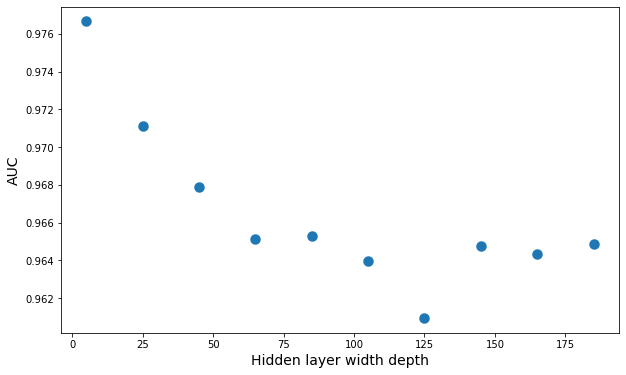

In [194]:
# Plot 'width' vs 'AUC' for a 'depth' of 5

wid_dep_df = pd.DataFrame(data= {'wid_dep': width_depth, 'AUC':auc_wid_dep})
wid_dep_df.sort_values(by='AUC', ascending= False).plot(kind='scatter',x='wid_dep', y='AUC', linewidth=6, figsize=(10,6))
plt.xlabel('Hidden layer width depth', fontsize=14)
plt.ylabel('AUC', fontsize=14)
plt.savefig('figures/Model/'+'AUC_vs_wid_dep'+'.png')
plt.show()

- With increase in hidden layer depth in general decrease trend has been seen for AUC metric
- With a depth of 5 layers, best model performance would be with hidden layer size of 5

#### Activation Function
The pros and cons of commonly used activation functions have been summarized below:

**Sigmoid and tanh**: Vanishing gradient, updates final layers faster than initial layers

<img src="Figures/Model/activation_sig_tan.PNG">

**ReLu**: 
<img src="Figures/Model/relu.PNG">
Faster, easy convergance, free from vanishing gradient problem. Dying ReLu problem, once a node gets negative number it becomes zero for the left ReLu curve and unlikely to produce any number. 

**Leaky ReLu**: Fixes the dying ReLu problem
<img src="Figures/Model/leaky_relu.PNG">

**Softmax**: Provides probabilities of numbers, suitable for output layer for classification problem
Images were taken from: [https://towardsdatascience.com/complete-guide-of-activation-functions-34076e95d044]

In this part, we will keep the last layer activation function as 'softmax' and the hidden layers as 'ReLu'. We will keep changing the first hidden layer activation function and see the performances.

In [415]:
# Define a baseline model to iterate over parameters---[Activation function]
# We will kepp changing the first hidden layer activation function with 'sigmoid', 'tanh', 'Leaky ReLu'

def tf_model_train_activation(train_inputs, train_targets, 
                        validation_inputs, validation_targets, 
                        test_inputs, test_targets):
    '''Function to train model based on input training data'''
    # Input/output layers size
    input_size = train_inputs.shape[0]
    output_size = 2
    
    # Hidden layer size
    hidden_layer_size = width
    
    # Model structure
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(hidden_layer_size, activation='sigmoid'), # 1st hidden layer
        tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 2nd hidden layer
        tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 3rd hidden layer
        tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 4th hidden layer
        tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 5th hidden layer
  
        
        tf.keras.layers.Dense(output_size, activation='softmax') # 'softmax' activation is suitable for classifier
    ])
    
    # Optimizer, loss function and metrics
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    ### Training
    # Batch size
    batch_size = 100
    # Number of training epochs
    max_epochs = 100
    
    # Early stopping: Allow for 2 instances of training after minimum loss point reached for for train/validation loss
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)
    
    
    # run the model 10 times and take average metrics
    auc_avg = []
    for i in range(10):
        # fit the model
        model.fit(train_inputs.values, # train inputs
              train_targets.values, # train targets
              batch_size=batch_size, # batch size
              epochs=max_epochs, # number of iteration the training will run, unless early stopping kicks in
              callbacks=[early_stopping], # early stopping
              validation_data=(validation_inputs.values, validation_targets.values), # validation data
              verbose = 2 # print minimum information during training
             )  
        # metrics
        y_prob = model.predict(test_inputs.values)
        # predicted class
        y_pred = y_prob.argmax(axis=-1)
        # calculate fpr, tpr
        fpr, tpr, thresholds = roc_curve(test_targets, y_prob[:,1], pos_label=1)
        # calculate AUC
        auc_roc = auc(fpr, tpr)
        auc_avg.append(auc_roc)
    
    
    return np.mean(auc_avg)

In [417]:
# Train the model with diferent activation functions for first hidden layer at a time

auc_activation = tf_model_train_activation(train_inputs_tf_hyp, train_targets_tf_hyp, 
                        validation_inputs_tf_hyp, validation_targets_tf_hyp, 
                        test_inputs_tf_hyp, test_targets_tf_hyp)

Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 13s - loss: 0.2433 - accuracy: 0.9029 - val_loss: 0.2205 - val_accuracy: 0.9124
Epoch 2/100
39720/39720 - 12s - loss: 0.1920 - accuracy: 0.9287 - val_loss: 0.1856 - val_accuracy: 0.9343
Epoch 3/100
39720/39720 - 13s - loss: 0.1830 - accuracy: 0.9331 - val_loss: 0.1774 - val_accuracy: 0.9384
Epoch 4/100
39720/39720 - 12s - loss: 0.1732 - accuracy: 0.9383 - val_loss: 0.1818 - val_accuracy: 0.9362
Epoch 5/100
39720/39720 - 12s - loss: 0.1696 - accuracy: 0.9397 - val_loss: 0.1681 - val_accuracy: 0.9422
Epoch 6/100
39720/39720 - 13s - loss: 0.1664 - accuracy: 0.9411 - val_loss: 0.1713 - val_accuracy: 0.9442
Epoch 7/100
39720/39720 - 13s - loss: 0.1639 - accuracy: 0.9424 - val_loss: 0.1670 - val_accuracy: 0.9430
Epoch 8/100
39720/39720 - 12s - loss: 0.1631 - accuracy: 0.9431 - val_loss: 0.1699 - val_accuracy: 0.9424
Epoch 9/100
39720/39720 - 18s - loss: 0.1608 - accuracy: 0.9436 - val_loss: 0.1764 - val_accuracy: 0.93

In [197]:
# Results after training models with combinations of 'activation' functions

df_activation = pd.DataFrame({'activation functions':['sigmoid', 'tanh', 'leaky ReLu', 'ReLu'], 'AUC': [0.9726, 0.9653, 0.9639, 0.9766]})
df_activation.sort_values(by='AUC', ascending=False)

activation functions     AUC
3                 ReLu  0.9766
0              sigmoid  0.9726
1                 tanh  0.9653
2           leaky ReLu  0.9639

- It has been observed that, all 'ReLu' in the hidden layers performed best for this dataset

#### Batch Size
For, Stochastic Gradient Descent (SGD): Batch size = 1. SGD is known for faster training time

Gradient Descent (GD): Batch size = sample size which is the slowest to train

Minibatch GD: Batch size is in between SGD and GD and a trade off between SGD and GD

We will try a ranges of 'batch size' to see which one yields best results

In [200]:
# Define a baseline model to iterate over parameters---[batch size]

def tf_model_train_batch(train_inputs, train_targets, 
                        validation_inputs, validation_targets, 
                        test_inputs, test_targets, batch):
    '''Function to train model based on input training data'''
    # Input/output layers size
    input_size = train_inputs.shape[0]
    output_size = 2
    
    # Hidden layer size
    hidden_layer_size = 5
    
    # Model structure
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 1st hidden layer
        tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 2nd hidden layer
        tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 3rd hidden layer
        tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 4th hidden layer
        tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 5th hidden layer
  
        
        tf.keras.layers.Dense(output_size, activation='softmax') # 'softmax' activation is suitable for classifier
    ])
    
    # Optimizer, loss function and metrics
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    ### Training
    # Batch size
    batch_size = batch
    # Number of training epochs
    max_epochs = 100
    
    # Early stopping: Allow for 2 instances of training after minimum loss point reached for for train/validation loss
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)
    
    
    # run the model 10 times and take average metrics
    auc_avg = []
    for i in range(10):
        # fit the model
        model.fit(train_inputs.values, # train inputs
              train_targets.values, # train targets
              batch_size=batch_size, # batch size
              epochs=max_epochs, # number of iteration the training will run, unless early stopping kicks in
              callbacks=[early_stopping], # early stopping
              validation_data=(validation_inputs.values, validation_targets.values), # validation data
              verbose = 2 # print minimum information during training
             )  
        # metrics
        y_prob = model.predict(test_inputs.values)
        # predicted class
        y_pred = y_prob.argmax(axis=-1)
        # calculate fpr, tpr
        fpr, tpr, thresholds = roc_curve(test_targets, y_prob[:,1], pos_label=1)
        # calculate AUC
        auc_roc = auc(fpr, tpr)
        auc_avg.append(auc_roc)
    
    
    return np.mean(auc_avg)

In [228]:
# Run a batch size of 1, 32, 64, 128, 256, 512

batch_size = np.array([1, 32, 64, 128, 256, 512])
auc_batch = []
for batch in batch_size:
    auc_temp = tf_model_train_batch(train_inputs_tf_hyp, train_targets_tf_hyp, 
                        validation_inputs_tf_hyp, validation_targets_tf_hyp, 
                        test_inputs_tf_hyp, test_targets_tf_hyp, batch)
    auc_batch.append(auc_temp)
    

Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 58s - loss: 0.2299 - accuracy: 0.9211 - val_loss: 0.1929 - val_accuracy: 0.9362
Epoch 2/100
39720/39720 - 56s - loss: 0.1865 - accuracy: 0.9358 - val_loss: 0.1892 - val_accuracy: 0.9376
Epoch 3/100
39720/39720 - 55s - loss: 0.1825 - accuracy: 0.9369 - val_loss: 0.1847 - val_accuracy: 0.9362
Epoch 4/100
39720/39720 - 56s - loss: 0.1801 - accuracy: 0.9388 - val_loss: 0.1849 - val_accuracy: 0.9388
Epoch 5/100
39720/39720 - 56s - loss: 0.1784 - accuracy: 0.9397 - val_loss: 0.1809 - val_accuracy: 0.9394
Epoch 6/100
39720/39720 - 56s - loss: 0.1770 - accuracy: 0.9398 - val_loss: 0.1924 - val_accuracy: 0.9335
Epoch 7/100
39720/39720 - 55s - loss: 0.1777 - accuracy: 0.9396 - val_loss: 0.1898 - val_accuracy: 0.9317
Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 56s - loss: 0.1754 - accuracy: 0.9402 - val_loss: 0.1861 - val_accuracy: 0.9331
Epoch 2/100
39720/39720 - 57s - loss: 0.1740 - accurac

Epoch 3/100
39720/39720 - 3s - loss: 0.1506 - accuracy: 0.9491 - val_loss: 0.1571 - val_accuracy: 0.9468
Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 3s - loss: 0.1495 - accuracy: 0.9500 - val_loss: 0.1608 - val_accuracy: 0.9458
Epoch 2/100
39720/39720 - 3s - loss: 0.1485 - accuracy: 0.9496 - val_loss: 0.1598 - val_accuracy: 0.9468
Epoch 3/100
39720/39720 - 3s - loss: 0.1498 - accuracy: 0.9495 - val_loss: 0.1600 - val_accuracy: 0.9464
Epoch 4/100
39720/39720 - 3s - loss: 0.1488 - accuracy: 0.9503 - val_loss: 0.1645 - val_accuracy: 0.9434
Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 3s - loss: 0.1482 - accuracy: 0.9504 - val_loss: 0.1595 - val_accuracy: 0.9468
Epoch 2/100
39720/39720 - 3s - loss: 0.1483 - accuracy: 0.9496 - val_loss: 0.1612 - val_accuracy: 0.9450
Epoch 3/100
39720/39720 - 3s - loss: 0.1478 - accuracy: 0.9502 - val_loss: 0.1553 - val_accuracy: 0.9488
Epoch 4/100
39720/39720 - 4s - loss: 0.1474 - accuracy: 0.9502

39720/39720 - 1s - loss: 0.1464 - accuracy: 0.9503 - val_loss: 0.1625 - val_accuracy: 0.9466
Epoch 5/100
39720/39720 - 1s - loss: 0.1440 - accuracy: 0.9518 - val_loss: 0.1575 - val_accuracy: 0.9492
Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 2s - loss: 0.1441 - accuracy: 0.9521 - val_loss: 0.1579 - val_accuracy: 0.9488
Epoch 2/100
39720/39720 - 1s - loss: 0.1465 - accuracy: 0.9506 - val_loss: 0.1578 - val_accuracy: 0.9486
Epoch 3/100
39720/39720 - 1s - loss: 0.1445 - accuracy: 0.9515 - val_loss: 0.1570 - val_accuracy: 0.9484
Epoch 4/100
39720/39720 - 1s - loss: 0.1441 - accuracy: 0.9520 - val_loss: 0.1604 - val_accuracy: 0.9468
Epoch 5/100
39720/39720 - 2s - loss: 0.1439 - accuracy: 0.9520 - val_loss: 0.1558 - val_accuracy: 0.9494
Epoch 6/100
39720/39720 - 1s - loss: 0.1443 - accuracy: 0.9520 - val_loss: 0.1625 - val_accuracy: 0.9458
Epoch 7/100
39720/39720 - 1s - loss: 0.1450 - accuracy: 0.9515 - val_loss: 0.1587 - val_accuracy: 0.9486
Train on 39720 sam

Epoch 2/100
39720/39720 - 1s - loss: 0.1411 - accuracy: 0.9527 - val_loss: 0.1612 - val_accuracy: 0.9474
Epoch 3/100
39720/39720 - 1s - loss: 0.1443 - accuracy: 0.9507 - val_loss: 0.1543 - val_accuracy: 0.9503
Epoch 4/100
39720/39720 - 1s - loss: 0.1401 - accuracy: 0.9529 - val_loss: 0.1554 - val_accuracy: 0.9482
Epoch 5/100
39720/39720 - 1s - loss: 0.1418 - accuracy: 0.9528 - val_loss: 0.1577 - val_accuracy: 0.9496
Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 1s - loss: 0.1410 - accuracy: 0.9527 - val_loss: 0.1609 - val_accuracy: 0.9462
Epoch 2/100
39720/39720 - 1s - loss: 0.1422 - accuracy: 0.9518 - val_loss: 0.1650 - val_accuracy: 0.9454
Epoch 3/100
39720/39720 - 1s - loss: 0.1428 - accuracy: 0.9518 - val_loss: 0.1546 - val_accuracy: 0.9496
Epoch 4/100
39720/39720 - 1s - loss: 0.1404 - accuracy: 0.9528 - val_loss: 0.1574 - val_accuracy: 0.9480
Epoch 5/100
39720/39720 - 1s - loss: 0.1407 - accuracy: 0.9525 - val_loss: 0.1647 - val_accuracy: 0.9446
Train 

Epoch 7/100
39720/39720 - 0s - loss: 0.1775 - accuracy: 0.9441 - val_loss: 0.1840 - val_accuracy: 0.9424
Epoch 8/100
39720/39720 - 0s - loss: 0.1726 - accuracy: 0.9450 - val_loss: 0.1809 - val_accuracy: 0.9432
Epoch 9/100
39720/39720 - 0s - loss: 0.1687 - accuracy: 0.9456 - val_loss: 0.1811 - val_accuracy: 0.9438
Epoch 10/100
39720/39720 - 0s - loss: 0.1662 - accuracy: 0.9467 - val_loss: 0.1758 - val_accuracy: 0.9440
Epoch 11/100
39720/39720 - 0s - loss: 0.1650 - accuracy: 0.9467 - val_loss: 0.1734 - val_accuracy: 0.9442
Epoch 12/100
39720/39720 - 0s - loss: 0.1620 - accuracy: 0.9474 - val_loss: 0.1715 - val_accuracy: 0.9456
Epoch 13/100
39720/39720 - 0s - loss: 0.1607 - accuracy: 0.9482 - val_loss: 0.1715 - val_accuracy: 0.9446
Epoch 14/100
39720/39720 - 0s - loss: 0.1597 - accuracy: 0.9476 - val_loss: 0.1742 - val_accuracy: 0.9422
Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 0s - loss: 0.1581 - accuracy: 0.9485 - val_loss: 0.1690 - val_accuracy: 0.9450
E

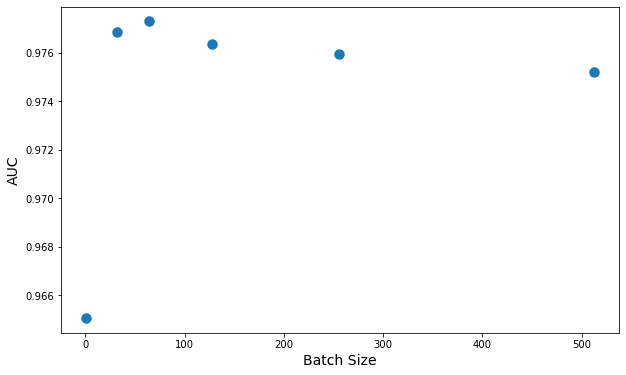

In [232]:
# Plot 'batch size' vs 'AUC' score 

batch_df = pd.DataFrame(data= {'batch_size': batch_size, 'AUC':auc_batch})
batch_df.sort_values(by='AUC', ascending= False).plot(kind='scatter',x='batch_size', y='AUC', linewidth=6, figsize=(10,6))
plt.xlabel('Batch Size', fontsize=14)
plt.ylabel('AUC', fontsize=14)
plt.savefig('figures/Model/'+'AUC_vs_batchsize'+'.png')
plt.show()

In [230]:
# print batch size for maximum AUC

maximum_auc_batch = batch_df.sort_values(by='AUC', ascending= False).iloc[0, :]
print('Maximum AUC is: {:.4f} for batch size {}'.format(maximum_auc_batch[1],maximum_auc_batch[0])) 

Maximum AUC is: 0.9773 for batch size 64.0


#### Learning Rate

In [256]:
# Define a baseline model to iterate over parameters---[learning rate]

def tf_model_train_lr(train_inputs, train_targets, 
                        validation_inputs, validation_targets, 
                        test_inputs, test_targets, lr):
    '''Function to train model based on input training data'''
    # Input/output layers size
    input_size = train_inputs.shape[0]
    output_size = 2
    
    # Hidden layer size
    hidden_layer_size = 5
    
    # Model structure
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 1st hidden layer
        tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 2nd hidden layer
        tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 3rd hidden layer
        tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 4th hidden layer
        tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 5th hidden layer
  
        
        tf.keras.layers.Dense(output_size, activation='softmax') # 'softmax' activation is suitable for classifier
    ])
    
    # Optimizer, loss function and metrics
    
    opt = tf.keras.optimizers.Adam(                                            # beta_1 = exponential decay rate for the first moment
    learning_rate= lr, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, # beta_2 = exponential decay rate for the second moment
    name='Adam')
    
    model.compile(optimizer= opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    ### Training
    # Batch size
    batch_size = 64
    # Number of training epochs
    max_epochs = 100
    
    # Early stopping: Allow for 2 instances of training after minimum loss point reached for for train/validation loss
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)
    
    
    # run the model 10 times and take average metrics
    auc_avg = []
    for i in range(10):
        # fit the model
        model.fit(train_inputs.values, # train inputs
              train_targets.values, # train targets
              batch_size=batch_size, # batch size
              epochs=max_epochs, # number of iteration the training will run, unless early stopping kicks in
              callbacks=[early_stopping], # early stopping
              validation_data=(validation_inputs.values, validation_targets.values), # validation data
              verbose = 2 # print minimum information during training
             )  
        # metrics
        y_prob = model.predict(test_inputs.values)
        # predicted class
        y_pred = y_prob.argmax(axis=-1)
        # calculate fpr, tpr
        fpr, tpr, thresholds = roc_curve(test_targets, y_prob[:,1], pos_label=1)
        # calculate AUC
        auc_roc = auc(fpr, tpr)
        auc_avg.append(auc_roc)
    
    
    return np.mean(auc_avg)

In [257]:
# Try learning rate of 0.0001, 0.001, 0.01, 0.1

learning_rate = np.array([0.0001, 0.001, 0.01, 0.1])
auc_lr = []
for lr in learning_rate:
    auc_temp = tf_model_train_lr(train_inputs_tf_hyp, train_targets_tf_hyp, 
                        validation_inputs_tf_hyp, validation_targets_tf_hyp, 
                        test_inputs_tf_hyp, test_targets_tf_hyp, lr)
    auc_lr.append(auc_temp)


Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 2s - loss: 0.6766 - accuracy: 0.5779 - val_loss: 0.6324 - val_accuracy: 0.6421
Epoch 2/100
39720/39720 - 1s - loss: 0.5640 - accuracy: 0.7411 - val_loss: 0.5027 - val_accuracy: 0.7968
Epoch 3/100
39720/39720 - 1s - loss: 0.4318 - accuracy: 0.8459 - val_loss: 0.3689 - val_accuracy: 0.8785
Epoch 4/100
39720/39720 - 1s - loss: 0.3109 - accuracy: 0.8967 - val_loss: 0.2705 - val_accuracy: 0.9094
Epoch 5/100
39720/39720 - 1s - loss: 0.2382 - accuracy: 0.9165 - val_loss: 0.2287 - val_accuracy: 0.9184
Epoch 6/100
39720/39720 - 1s - loss: 0.2088 - accuracy: 0.9270 - val_loss: 0.2079 - val_accuracy: 0.9261
Epoch 7/100
39720/39720 - 1s - loss: 0.1948 - accuracy: 0.9325 - val_loss: 0.1993 - val_accuracy: 0.9313
Epoch 8/100
39720/39720 - 1s - loss: 0.1874 - accuracy: 0.9360 - val_loss: 0.1941 - val_accuracy: 0.9337
Epoch 9/100
39720/39720 - 1s - loss: 0.1822 - accuracy: 0.9381 - val_loss: 0.1906 - val_accuracy: 0.9351
Epoch 

Epoch 2/100
39720/39720 - 1s - loss: 0.1546 - accuracy: 0.9489 - val_loss: 0.1672 - val_accuracy: 0.9468
Epoch 3/100
39720/39720 - 1s - loss: 0.1532 - accuracy: 0.9487 - val_loss: 0.1652 - val_accuracy: 0.9454
Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 1s - loss: 0.1525 - accuracy: 0.9491 - val_loss: 0.1608 - val_accuracy: 0.9484
Epoch 2/100
39720/39720 - 1s - loss: 0.1516 - accuracy: 0.9498 - val_loss: 0.1627 - val_accuracy: 0.9474
Epoch 3/100
39720/39720 - 1s - loss: 0.1497 - accuracy: 0.9499 - val_loss: 0.1598 - val_accuracy: 0.9478
Epoch 4/100
39720/39720 - 1s - loss: 0.1497 - accuracy: 0.9499 - val_loss: 0.1662 - val_accuracy: 0.9446
Epoch 5/100
39720/39720 - 1s - loss: 0.1483 - accuracy: 0.9512 - val_loss: 0.1638 - val_accuracy: 0.9464
Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 1s - loss: 0.1490 - accuracy: 0.9510 - val_loss: 0.1627 - val_accuracy: 0.9472
Epoch 2/100
39720/39720 - 1s - loss: 0.1483 - accuracy: 0.9505

Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 1s - loss: 0.1518 - accuracy: 0.9490 - val_loss: 0.1607 - val_accuracy: 0.9462
Epoch 2/100
39720/39720 - 1s - loss: 0.1508 - accuracy: 0.9487 - val_loss: 0.1614 - val_accuracy: 0.9454
Epoch 3/100
39720/39720 - 1s - loss: 0.1510 - accuracy: 0.9491 - val_loss: 0.1569 - val_accuracy: 0.9478
Epoch 4/100
39720/39720 - 1s - loss: 0.1495 - accuracy: 0.9496 - val_loss: 0.1652 - val_accuracy: 0.9440
Epoch 5/100
39720/39720 - 2s - loss: 0.1495 - accuracy: 0.9494 - val_loss: 0.1597 - val_accuracy: 0.9476
Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 2s - loss: 0.1497 - accuracy: 0.9494 - val_loss: 0.1625 - val_accuracy: 0.9456
Epoch 2/100
39720/39720 - 1s - loss: 0.1505 - accuracy: 0.9493 - val_loss: 0.1629 - val_accuracy: 0.9446
Epoch 3/100
39720/39720 - 2s - loss: 0.1500 - accuracy: 0.9492 - val_loss: 0.1546 - val_accuracy: 0.9492
Epoch 4/100
39720/39720 - 1s - loss: 0.1496 - accuracy: 0.9498

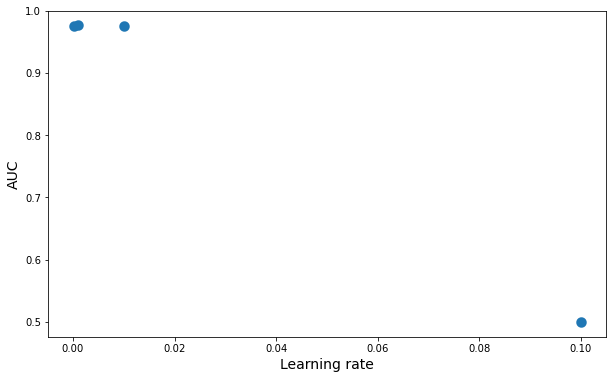

In [258]:
# 'learning rate' vs 'AUC' score

lr_df = pd.DataFrame(data= {'learning_rate': learning_rate, 'AUC':auc_lr})
lr_df.sort_values(by='AUC', ascending= False).plot(kind='scatter',x='learning_rate', y='AUC', linewidth=6, figsize=(10,6))
plt.xlabel('Learning rate', fontsize=14)
plt.ylabel('AUC', fontsize=14)
plt.savefig('figures/Model/'+'AUC_vs_learning_rate'+'.png')
plt.show()

In [259]:
# print optimum learning rate for maximum AUC

maximum_auc_lr = lr_df.sort_values(by='AUC', ascending= False).iloc[0, :]
print('Maximum AUC is: {:.4f} for learning rate {}'.format(maximum_auc_lr[1],maximum_auc_lr[0])) 

Maximum AUC is: 0.9763 for learning rate 0.001


- Maximum AUC is achieved for the default learning rate of 0.001

### Dropout
Dropout is a technique to reduce overfitting during training in the model. By specifying dropout, we are telling the model to ignore specified number of nodes, so that the other nodes can take on more responsibility to learn.
Dropout can be added to the input layer as well as to the hidden layers. A maximum dropout rate of 0.5 provides maximum regularization also may results in under learning. Too much low drop out rate on the other hand may be too insensitive to learning. 
We will eplore the folloing scenarion:
1. Dropout at the input layer vs no dropout
2. For hidden layers, vary dropout rate between 0.0 (without dropout) to 0.4 

In [275]:
# Define a baseline model to iterate over parameters---[Drop out rate]

def tf_model_train_drop(train_inputs, train_targets, 
                        validation_inputs, validation_targets, 
                        test_inputs, test_targets, dr):
    '''Function to train model based on input training data'''
    # Input/output layers size
    input_size = train_inputs.shape[0]
    output_size = 2
    
    # Hidden layer size
    hidden_layer_size = 5
    
    # Model structure
    model = tf.keras.Sequential([
        #tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 1st hidden layer
        tf.keras.layers.Dropout(dr),
        tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 2nd hidden layer
        tf.keras.layers.Dropout(dr),
        tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 3rd hidden layer
        tf.keras.layers.Dropout(dr),
        tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 4th hidden layer
        tf.keras.layers.Dropout(dr),
        tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 5th hidden layer
        tf.keras.layers.Dropout(dr),
        
        tf.keras.layers.Dense(output_size, activation='softmax') # 'softmax' activation is suitable for classifier
    ])
    
    # Optimizer, loss function and metrics
    
    opt = tf.keras.optimizers.Adam(                                            # beta_1 = exponential decay rate for the first moment
    learning_rate= 0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, # beta_2 = exponential decay rate for the second moment
    name='Adam')
    
    model.compile(optimizer= opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    ### Training
    # Batch size
    batch_size = 64
    # Number of training epochs
    max_epochs = 100
    
    # Early stopping: Allow for 2 instances of training after minimum loss point reached for for train/validation loss
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)
    
    
    # run the model 10 times and take average metrics
    auc_avg = []
    for i in range(10):
        # fit the model
        model.fit(train_inputs.values, # train inputs
              train_targets.values, # train targets
              batch_size=batch_size, # batch size
              epochs=max_epochs, # number of iteration the training will run, unless early stopping kicks in
              callbacks=[early_stopping], # early stopping
              validation_data=(validation_inputs.values, validation_targets.values), # validation data
              verbose = 2 # print minimum information during training
             )  
        # metrics
        y_prob = model.predict(test_inputs.values)
        # predicted class
        y_pred = y_prob.argmax(axis=-1)
        # calculate fpr, tpr
        fpr, tpr, thresholds = roc_curve(test_targets, y_prob[:,1], pos_label=1)
        # calculate AUC
        auc_roc = auc(fpr, tpr)
        auc_avg.append(auc_roc)
    
    
    return np.mean(auc_avg)

In [276]:
# Try dropout rate of 0.0, 0.1, 0.2, 0.3, 0.4

drop_rate = np.array([0.0, 0.1, 0.2, 0.3, 0.4])
auc_dr= []
for dr in drop_rate:
    auc_temp = tf_model_train_drop(train_inputs_tf_hyp, train_targets_tf_hyp, 
                        validation_inputs_tf_hyp, validation_targets_tf_hyp, 
                        test_inputs_tf_hyp, test_targets_tf_hyp, dr)
    auc_dr.append(auc_temp)

Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 3s - loss: 0.3645 - accuracy: 0.8692 - val_loss: 0.2357 - val_accuracy: 0.9378
Epoch 2/100
39720/39720 - 2s - loss: 0.2033 - accuracy: 0.9422 - val_loss: 0.1914 - val_accuracy: 0.9418
Epoch 3/100
39720/39720 - 2s - loss: 0.1789 - accuracy: 0.9442 - val_loss: 0.1732 - val_accuracy: 0.9462
Epoch 4/100
39720/39720 - 2s - loss: 0.1686 - accuracy: 0.9466 - val_loss: 0.1908 - val_accuracy: 0.9351
Epoch 5/100
39720/39720 - 2s - loss: 0.1649 - accuracy: 0.9469 - val_loss: 0.1695 - val_accuracy: 0.9452
Epoch 6/100
39720/39720 - 2s - loss: 0.1594 - accuracy: 0.9484 - val_loss: 0.1650 - val_accuracy: 0.9462
Epoch 7/100
39720/39720 - 2s - loss: 0.1579 - accuracy: 0.9475 - val_loss: 0.1662 - val_accuracy: 0.9446
Epoch 8/100
39720/39720 - 2s - loss: 0.1544 - accuracy: 0.9490 - val_loss: 0.1654 - val_accuracy: 0.9460
Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 2s - loss: 0.1539 - accuracy: 0.9484

Epoch 4/100
39720/39720 - 2s - loss: 0.1653 - accuracy: 0.9450 - val_loss: 0.1639 - val_accuracy: 0.9446
Epoch 5/100
39720/39720 - 2s - loss: 0.1672 - accuracy: 0.9436 - val_loss: 0.1647 - val_accuracy: 0.9468
Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 2s - loss: 0.1647 - accuracy: 0.9442 - val_loss: 0.1629 - val_accuracy: 0.9446
Epoch 2/100
39720/39720 - 2s - loss: 0.1656 - accuracy: 0.9442 - val_loss: 0.1642 - val_accuracy: 0.9454
Epoch 3/100
39720/39720 - 2s - loss: 0.1657 - accuracy: 0.9443 - val_loss: 0.1590 - val_accuracy: 0.9492
Epoch 4/100
39720/39720 - 2s - loss: 0.1647 - accuracy: 0.9444 - val_loss: 0.1646 - val_accuracy: 0.9442
Epoch 5/100
39720/39720 - 2s - loss: 0.1661 - accuracy: 0.9450 - val_loss: 0.1612 - val_accuracy: 0.9474
Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 2s - loss: 0.1642 - accuracy: 0.9444 - val_loss: 0.1593 - val_accuracy: 0.9478
Epoch 2/100
39720/39720 - 2s - loss: 0.1659 - accuracy: 0.9436

39720/39720 - 2s - loss: 0.1811 - accuracy: 0.9399 - val_loss: 0.1634 - val_accuracy: 0.9472
Epoch 3/100
39720/39720 - 2s - loss: 0.1817 - accuracy: 0.9399 - val_loss: 0.1818 - val_accuracy: 0.9374
Epoch 4/100
39720/39720 - 2s - loss: 0.1814 - accuracy: 0.9398 - val_loss: 0.1760 - val_accuracy: 0.9448
Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 2s - loss: 0.1816 - accuracy: 0.9400 - val_loss: 0.1717 - val_accuracy: 0.9440
Epoch 2/100
39720/39720 - 2s - loss: 0.1810 - accuracy: 0.9403 - val_loss: 0.1693 - val_accuracy: 0.9464
Epoch 3/100
39720/39720 - 2s - loss: 0.1799 - accuracy: 0.9410 - val_loss: 0.1690 - val_accuracy: 0.9462
Epoch 4/100
39720/39720 - 2s - loss: 0.1811 - accuracy: 0.9404 - val_loss: 0.1695 - val_accuracy: 0.9468
Epoch 5/100
39720/39720 - 2s - loss: 0.1816 - accuracy: 0.9401 - val_loss: 0.1683 - val_accuracy: 0.9474
Epoch 6/100
39720/39720 - 2s - loss: 0.1800 - accuracy: 0.9412 - val_loss: 0.1693 - val_accuracy: 0.9458
Epoch 7/100
39720/

Epoch 4/100
39720/39720 - 2s - loss: 0.5167 - accuracy: 0.7845 - val_loss: 0.3967 - val_accuracy: 0.8834
Epoch 5/100
39720/39720 - 2s - loss: 0.4981 - accuracy: 0.7982 - val_loss: 0.3551 - val_accuracy: 0.9142
Epoch 6/100
39720/39720 - 2s - loss: 0.4865 - accuracy: 0.8073 - val_loss: 0.3266 - val_accuracy: 0.9249
Epoch 7/100
39720/39720 - 2s - loss: 0.4768 - accuracy: 0.8115 - val_loss: 0.3170 - val_accuracy: 0.9269
Epoch 8/100
39720/39720 - 2s - loss: 0.4847 - accuracy: 0.8106 - val_loss: 0.3353 - val_accuracy: 0.9225
Epoch 9/100
39720/39720 - 2s - loss: 0.4764 - accuracy: 0.8133 - val_loss: 0.3239 - val_accuracy: 0.9297
Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 2s - loss: 0.4810 - accuracy: 0.8120 - val_loss: 0.3422 - val_accuracy: 0.9090
Epoch 2/100
39720/39720 - 2s - loss: 0.4713 - accuracy: 0.8189 - val_loss: 0.3256 - val_accuracy: 0.9184
Epoch 3/100
39720/39720 - 2s - loss: 0.4671 - accuracy: 0.8193 - val_loss: 0.3147 - val_accuracy: 0.9269
Epoch 

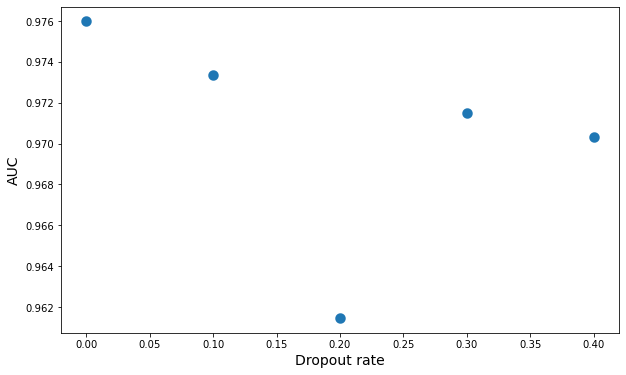

In [277]:
# Plot 'drop out rate' vs 'AUC'

dr_df = pd.DataFrame(data= {'dropout_rate': drop_rate, 'AUC':auc_dr})
dr_df.sort_values(by='AUC', ascending= False).plot(kind='scatter',x='dropout_rate', y='AUC', linewidth=6, figsize=(10,6))
plt.xlabel('Dropout rate', fontsize=14)
plt.ylabel('AUC', fontsize=14)
plt.savefig('figures/Model/'+'AUC_vs_drop_rate'+'.png')
plt.show()

In [278]:
# print optimum dropout rate for maximum AUC

maximum_auc_dr = dr_df.sort_values(by='AUC', ascending= False).iloc[0, :]
print('Maximum AUC is: {:.4f} for dropout rate {}'.format(maximum_auc_dr[1],maximum_auc_dr[0])) 

Maximum AUC is: 0.9760 for dropout rate 0.0


- Adding dropout layer at the input worsened the model performance
- Learning rate also increased but 0.001 produced best performances
- For this dataset, performance is better wothout any dropout layer

### Hyper-paramter Optimized Model
The following optimized hyper-parameters have been found:
- Width: 5
- Depth: 5
- Activation: ReLu for the hidden layers
- Batch-size: 64
- Learningrate: 0.001
- Dropout: No dropout
With these we will train Deep Learing model for the data set and measure performances

In [42]:
# Define hyper-parameter optimized deep learning model 

def tf_model_train_hp(train_inputs, train_targets, validation_inputs, validation_targets, test_inputs, test_targets):
    '''Function to train model based on input training data'''
    # Input/output layers size
    input_size = train_inputs.shape[0]
    output_size = 2
    
    # Hidden layer size
    hidden_layer_size = 5
    
    # Model structure
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 1st hidden layer
        tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 2nd hidden layer
        tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 3rd hidden layer
        tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 4th hidden layer
        tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 5th hidden layer
        
        tf.keras.layers.Dense(output_size, activation='softmax') # 'softmax' activation is suitable for classifier
    ])
    
    # Optimizer, loss function and metrics
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    ### Training
    # Batch size
    batch_size = 64
    # Number of training epochs
    max_epochs = 100
    
    # Early stopping: Allow for 2 instances of training after minimum loss point reached for for train/validation loss
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)
    
    
    # fit the model
    train_mod = model.fit(train_inputs.values, # train inputs
              train_targets.values, # train targets
              batch_size=batch_size, # batch size
              epochs=max_epochs, # number of iteration the training will run, unless early stopping kicks in
              callbacks=[early_stopping], # early stopping
              validation_data=(validation_inputs.values, validation_targets.values), # validation data
              verbose = 2 # print minimum information during training
             )  
    
    return train_mod, model


In [154]:
# Function to calculate model metrices (Accuracy, AUC, FPR, TPR)

def model_metrics_tf(train_inputs, train_targets, validation_inputs, validation_targets, test_inputs, test_targets):
    
    '''function to calculate and return specified model metrics'''
    
    # run model for 10 times and take average
    accuracy_avg=[]
    auc_avg=[]
    y_prob_avg = []
    y_class_avg = []
    
    for i in range(10):
        train_mode, model = tf_model_train_hp(train_inputs, train_targets, validation_inputs, validation_targets, test_inputs, test_targets)
        # accuracy
        test_loss, accuracy = model.evaluate(test_inputs.values, test_targets.values)
        # probabilities
        y_prob = model.predict(test_inputs.values)
        
        # predicted class
        y_pred = y_prob.argmax(axis=-1)
        
        # calculate fpr, tpr
        fpr, tpr, thresholds = roc_curve(test_targets, y_prob[:,1], pos_label=1)
        
        y_prob=y_prob[:,1]
        
        # calculate AUC
        auc_roc = auc(fpr, tpr)
        
        # apend results at every iteration
        accuracy_avg.append(accuracy)
        auc_avg.append(auc_roc)
        y_prob_avg.append(y_prob.ravel())
        y_class_avg.append(y_pred)
    
    return np.mean(accuracy_avg), np.mean(auc_avg), fpr, tpr, np.where(np.mean(y_class_avg, axis=0)>.5, 1, 0), np.mean(y_prob_avg, axis=0)
    

In [155]:
# Measure model metrics

accuracy_tf, auc_roc_tf, fpr_tf, tpr_tf, y_class_tf, y_prob_tf = model_metrics_tf(train_inputs_tf_hyp, train_targets_tf_hyp, validation_inputs_tf_hyp, validation_targets_tf_hyp, test_inputs_tf_hyp, test_targets_tf_hyp)

Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 2s - loss: 0.3830 - accuracy: 0.8516 - val_loss: 0.2350 - val_accuracy: 0.9372
Epoch 2/100
39720/39720 - 2s - loss: 0.2032 - accuracy: 0.9414 - val_loss: 0.1950 - val_accuracy: 0.9396
Epoch 3/100
39720/39720 - 2s - loss: 0.1792 - accuracy: 0.9436 - val_loss: 0.1768 - val_accuracy: 0.9448
Epoch 4/100
39720/39720 - 2s - loss: 0.1702 - accuracy: 0.9453 - val_loss: 0.1918 - val_accuracy: 0.9376
Epoch 5/100
39720/39720 - 2s - loss: 0.1685 - accuracy: 0.9457 - val_loss: 0.1752 - val_accuracy: 0.9440
Epoch 6/100
39720/39720 - 2s - loss: 0.1664 - accuracy: 0.9471 - val_loss: 0.1742 - val_accuracy: 0.9452
Epoch 7/100
39720/39720 - 2s - loss: 0.1659 - accuracy: 0.9474 - val_loss: 0.1732 - val_accuracy: 0.9442
Epoch 8/100
39720/39720 - 2s - loss: 0.1651 - accuracy: 0.9479 - val_loss: 0.1743 - val_accuracy: 0.9438
Epoch 9/100
39720/39720 - 2s - loss: 0.1640 - accuracy: 0.9477 - val_loss: 0.1699 - val_accuracy: 0.9474
Epoch 

Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 2s - loss: 0.3370 - accuracy: 0.8656 - val_loss: 0.1911 - val_accuracy: 0.9376
Epoch 2/100
39720/39720 - 1s - loss: 0.1769 - accuracy: 0.9414 - val_loss: 0.1793 - val_accuracy: 0.9420
Epoch 3/100
39720/39720 - 2s - loss: 0.1721 - accuracy: 0.9438 - val_loss: 0.1750 - val_accuracy: 0.9448
Epoch 4/100
39720/39720 - 1s - loss: 0.1695 - accuracy: 0.9452 - val_loss: 0.2053 - val_accuracy: 0.9315
Epoch 5/100
39720/39720 - 1s - loss: 0.1690 - accuracy: 0.9455 - val_loss: 0.1783 - val_accuracy: 0.9436
4965/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 2s - loss: 0.3408 - accuracy: 0.8413 - val_loss: 0.1861 - val_accuracy: 0.9355
Epoch 2/100
39720/39720 - 2s - loss: 0.1754 - accuracy: 0.9401 - val_loss: 0.1835 - val_accuracy: 0.9372
Epoch 3/100
39720/39720 - 1s - loss: 0.1687 - accuracy: 0.9428 - val_loss: 0.1725 - val_accuracy: 0.9432
Epoch 4/100
39720/39720 - 1s - loss: 0.1638 - accuracy: 0.9457 - val_loss: 0.1709 - val_accuracy: 0.9426
Epoch 5/100
39720/39720 - 1s - loss: 0.1614 - accuracy: 0.9453 - val_loss: 0.1698 - val_accuracy: 0.9456
Epoch 6/100
39720/39720 - 1s - loss: 0.1578 - accuracy: 0.9466 - val_loss: 0.1661 - val_accuracy: 0.9468
Epoch 7/100
39720/39720 - 1s - loss: 0.1573 - accuracy: 0.9466 - val_loss: 0.1648 - val_accuracy: 0.9462
Epoch 8/100
39720/39720 - 1s - loss: 0.1545 - accuracy: 0.9476 - val_loss: 0.1691 - val_accuracy: 0.9442
Epoch 9/100
39720/39720 - 1s - loss: 0.1546 - accuracy: 0.9472 - val_loss: 0.1636 - val_accuracy: 0.9458
Epoch 

Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 2s - loss: 0.4052 - accuracy: 0.8601 - val_loss: 0.2427 - val_accuracy: 0.9327
Epoch 2/100
39720/39720 - 2s - loss: 0.2054 - accuracy: 0.9377 - val_loss: 0.2019 - val_accuracy: 0.9349
Epoch 3/100
39720/39720 - 2s - loss: 0.1838 - accuracy: 0.9405 - val_loss: 0.1908 - val_accuracy: 0.9384
Epoch 4/100
39720/39720 - 2s - loss: 0.1773 - accuracy: 0.9426 - val_loss: 0.1841 - val_accuracy: 0.9392
Epoch 5/100
39720/39720 - 2s - loss: 0.1739 - accuracy: 0.9437 - val_loss: 0.1826 - val_accuracy: 0.9424
Epoch 6/100
39720/39720 - 2s - loss: 0.1711 - accuracy: 0.9438 - val_loss: 0.1783 - val_accuracy: 0.9454
Epoch 7/100
39720/39720 - 2s - loss: 0.1688 - accuracy: 0.9449 - val_loss: 0.1802 - val_accuracy: 0.9434
Epoch 8/100
39720/39720 - 1s - loss: 0.1667 - accuracy: 0.9448 - val_loss: 0.1820 - val_accuracy: 0.9392
4965/1 [=======================================================================================================

Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 2s - loss: 0.3216 - accuracy: 0.8545 - val_loss: 0.1850 - val_accuracy: 0.9368
Epoch 2/100
39720/39720 - 2s - loss: 0.1736 - accuracy: 0.9402 - val_loss: 0.1772 - val_accuracy: 0.9412
Epoch 3/100
39720/39720 - 2s - loss: 0.1680 - accuracy: 0.9424 - val_loss: 0.1738 - val_accuracy: 0.9406
Epoch 4/100
39720/39720 - 2s - loss: 0.1641 - accuracy: 0.9446 - val_loss: 0.1684 - val_accuracy: 0.9450
Epoch 5/100
39720/39720 - 1s - loss: 0.1616 - accuracy: 0.9453 - val_loss: 0.1725 - val_accuracy: 0.9430
Epoch 6/100
39720/39720 - 2s - loss: 0.1585 - accuracy: 0.9456 - val_loss: 0.1645 - val_accuracy: 0.9472
Epoch 7/100
39720/39720 - 2s - loss: 0.1576 - accuracy: 0.9458 - val_loss: 0.1638 - val_accuracy: 0.9458
Epoch 8/100
39720/39720 - 2s - loss: 0.1554 - accuracy: 0.9467 - val_loss: 0.1707 - val_accuracy: 0.9418
Epoch 9/100
39720/39720 - 1s - loss: 0.1562 - accuracy: 0.9465 - val_loss: 0.1692 - val_accuracy: 0.9452
4965/1

Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 2s - loss: 0.3258 - accuracy: 0.8502 - val_loss: 0.1893 - val_accuracy: 0.9351
Epoch 2/100
39720/39720 - 1s - loss: 0.1761 - accuracy: 0.9390 - val_loss: 0.1794 - val_accuracy: 0.9388
Epoch 3/100
39720/39720 - 1s - loss: 0.1681 - accuracy: 0.9426 - val_loss: 0.1733 - val_accuracy: 0.9416
Epoch 4/100
39720/39720 - 1s - loss: 0.1619 - accuracy: 0.9452 - val_loss: 0.1717 - val_accuracy: 0.9418
Epoch 5/100
39720/39720 - 2s - loss: 0.1579 - accuracy: 0.9466 - val_loss: 0.1681 - val_accuracy: 0.9450
Epoch 6/100
39720/39720 - 1s - loss: 0.1549 - accuracy: 0.9475 - val_loss: 0.1637 - val_accuracy: 0.9470
Epoch 7/100
39720/39720 - 1s - loss: 0.1544 - accuracy: 0.9474 - val_loss: 0.1657 - val_accuracy: 0.9448
Epoch 8/100
39720/39720 - 1s - loss: 0.1524 - accuracy: 0.9482 - val_loss: 0.1660 - val_accuracy: 0.9450
4965/1 [=======================================================================================================

Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 2s - loss: 0.3843 - accuracy: 0.8216 - val_loss: 0.2040 - val_accuracy: 0.9339
Epoch 2/100
39720/39720 - 1s - loss: 0.1829 - accuracy: 0.9383 - val_loss: 0.1860 - val_accuracy: 0.9364
Epoch 3/100
39720/39720 - 1s - loss: 0.1721 - accuracy: 0.9416 - val_loss: 0.1761 - val_accuracy: 0.9432
Epoch 4/100
39720/39720 - 1s - loss: 0.1673 - accuracy: 0.9443 - val_loss: 0.1796 - val_accuracy: 0.9400
Epoch 5/100
39720/39720 - 1s - loss: 0.1665 - accuracy: 0.9446 - val_loss: 0.1763 - val_accuracy: 0.9414
4965/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 2s - loss: 0.3179 - accuracy: 0.8652 - val_loss: 0.1818 - val_accuracy: 0.9378
Epoch 2/100
39720/39720 - 2s - loss: 0.1715 - accuracy: 0.9423 - val_loss: 0.1789 - val_accuracy: 0.9390
Epoch 3/100
39720/39720 - 1s - loss: 0.1678 - accuracy: 0.9434 - val_loss: 0.1728 - val_accuracy: 0.9436
Epoch 4/100
39720/39720 - 1s - loss: 0.1637 - accuracy: 0.9454 - val_loss: 0.1715 - val_accuracy: 0.9450
Epoch 5/100
39720/39720 - 1s - loss: 0.1619 - accuracy: 0.9462 - val_loss: 0.1720 - val_accuracy: 0.9444
Epoch 6/100
39720/39720 - 2s - loss: 0.1593 - accuracy: 0.9473 - val_loss: 0.1704 - val_accuracy: 0.9462
Epoch 7/100
39720/39720 - 1s - loss: 0.1589 - accuracy: 0.9468 - val_loss: 0.1693 - val_accuracy: 0.9440
Epoch 8/100
39720/39720 - 1s - loss: 0.1562 - accuracy: 0.9477 - val_loss: 0.1715 - val_accuracy: 0.9434
Epoch 9/100
39720/39720 - 1s - loss: 0.1560 - accuracy: 0.9471 - val_loss: 0.1652 - val_accuracy: 0.9480
Epoch 

Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 2s - loss: 0.2863 - accuracy: 0.8825 - val_loss: 0.1851 - val_accuracy: 0.9364
Epoch 2/100
39720/39720 - 1s - loss: 0.1731 - accuracy: 0.9405 - val_loss: 0.1821 - val_accuracy: 0.9384
Epoch 3/100
39720/39720 - 1s - loss: 0.1696 - accuracy: 0.9423 - val_loss: 0.1741 - val_accuracy: 0.9392
Epoch 4/100
39720/39720 - 1s - loss: 0.1639 - accuracy: 0.9449 - val_loss: 0.1704 - val_accuracy: 0.9442
Epoch 5/100
39720/39720 - 1s - loss: 0.1621 - accuracy: 0.9457 - val_loss: 0.1690 - val_accuracy: 0.9434
Epoch 6/100
39720/39720 - 1s - loss: 0.1584 - accuracy: 0.9467 - val_loss: 0.1669 - val_accuracy: 0.9456
Epoch 7/100
39720/39720 - 1s - loss: 0.1587 - accuracy: 0.9460 - val_loss: 0.1670 - val_accuracy: 0.9448
Epoch 8/100
39720/39720 - 1s - loss: 0.1547 - accuracy: 0.9474 - val_loss: 0.1685 - val_accuracy: 0.9440
4965/1 [=======================================================================================================

Train on 39720 samples, validate on 4965 samples
Epoch 1/100
39720/39720 - 2s - loss: 0.3366 - accuracy: 0.8628 - val_loss: 0.1890 - val_accuracy: 0.9337
Epoch 2/100
39720/39720 - 1s - loss: 0.1799 - accuracy: 0.9390 - val_loss: 0.1835 - val_accuracy: 0.9353
Epoch 3/100
39720/39720 - 1s - loss: 0.1719 - accuracy: 0.9415 - val_loss: 0.1739 - val_accuracy: 0.9422
Epoch 4/100
39720/39720 - 1s - loss: 0.1635 - accuracy: 0.9449 - val_loss: 0.1675 - val_accuracy: 0.9436
Epoch 5/100
39720/39720 - 1s - loss: 0.1585 - accuracy: 0.9458 - val_loss: 0.1700 - val_accuracy: 0.9434
Epoch 6/100
39720/39720 - 1s - loss: 0.1549 - accuracy: 0.9478 - val_loss: 0.1626 - val_accuracy: 0.9458
Epoch 7/100
39720/39720 - 1s - loss: 0.1540 - accuracy: 0.9476 - val_loss: 0.1629 - val_accuracy: 0.9460
Epoch 8/100
39720/39720 - 1s - loss: 0.1516 - accuracy: 0.9489 - val_loss: 0.1631 - val_accuracy: 0.9448
4965/1 [=======================================================================================================

In [45]:
# accuracy, AUC

print('Test accuracy is: {:.2f}%'.format(100*accuracy_tf))
print('AUC-ROC value is: {:.4f}'.format(auc_roc_tf))

Test accuracy is: 94.43%
AUC-ROC value is: 0.9732


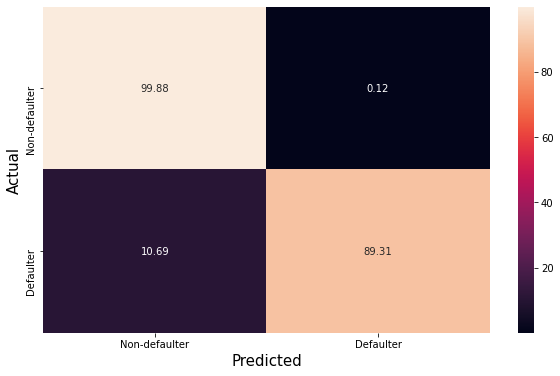

In [293]:
plot_confusion_matrix(test_targets_tf_hyp, y_class_tf, 'CM_base_hp_TF')

- The hyperparameter optimized TF model yielded a small imprivement in test accuracy (94.49%)
- Small improvement in two class separability (AUC of 0.9756)
- A little lower false negative (FN) (10.69%) although it is still higher than false positive (FP). That means the classifier will allow more loan defaulter to get loan relative to blocking a non-defaulter to get loans
- As a loan provider organization it is desirable to minimize FN as it would like to allow less actual defaulter people to take loans. Reducing FN will cost the organization by increased amount of FP. We need to find balance

In [46]:
# Save results in dataframe

df_accuracy = pd.DataFrame(data = [{'TF': accuracy_tf}])
df_auc = pd.DataFrame(data = [{'TF':auc_roc_tf}])

## Random Forest
Random Forest is a popular algorithm which build trees and combines the results learned from each trees into one at the end of the training. This algorithm is suitable for noisy and multiclass data. It also has advantage of less over fitting.


Most important hyper-parameters for Random Forest model are number of toal trees (n_estimators) and number of features considered for splitting at each node (max_features).

Hyper-parameter optimization for Random Forest has been discussed here: [https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76]

### Data Preparation
- Data was tweaked for standardized vs non-standardized version for simple random forest classifier
- Non standardized version yielded better AUC score, so we will be using non-standard data for this section

In [170]:
# Columns to keep
columns_to_keep = list(list(df_one_hot_code)+list(df_num.columns))
columns_to_keep = list(set(columns_to_keep)-set(['TARGET']))

# Train set
train_inputs_rf = train_df[columns_to_keep]
train_targets_rf = train_df['TARGET']

# Validation set
validation_inputs_rf = validation_df[columns_to_keep]
validation_targets_rf = validation_df['TARGET']

# Test set
test_inputs_rf = test_df[columns_to_keep]
test_targets_rf = test_df['TARGET']

In [171]:
# Append train and validation data to form one frame as the Random Forest classifier 
# can cross validate by the specified times on the training data

train_inputs_rf = pd.concat([train_inputs_rf, validation_inputs_rf])
train_targets_rf = pd.concat([train_targets_rf, validation_targets_rf])

### Hyperparameter Optimization

In [172]:
# Random Forest hyperparameter grid

parameter_grid_rf = {'n_estimators': np.linspace(10, 200).astype(int),  # Number of trees 
               'max_features': ['auto', 'sqrt'],   # Number of features to split at every nodes
               'max_depth': [None] + list(np.linspace(3, 20).astype(int)),   # Maximum number of levels in tree
               'min_samples_split': [2, 5, 10],    # Minimum number of samples required to split a node
               'min_samples_leaf': [1, 2, 4],      # Minimum number of samples required at each leaf node
               'bootstrap': [True, False]}         # Method of selecting samples for training each tree
print('Hyperparameter grid for randomforest classifier',parameter_grid_rf)

Hyperparameter grid for randomforest classifier {'n_estimators': array([ 10,  13,  17,  21,  25,  29,  33,  37,  41,  44,  48,  52,  56,
        60,  64,  68,  72,  75,  79,  83,  87,  91,  95,  99, 103, 106,
       110, 114, 118, 122, 126, 130, 134, 137, 141, 145, 149, 153, 157,
       161, 165, 168, 172, 176, 180, 184, 188, 192, 196, 200]), 'max_features': ['auto', 'sqrt'], 'max_depth': [None, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 11, 12, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 15, 16, 16, 16, 17, 17, 17, 18, 18, 18, 19, 19, 20], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [173]:
# Train model based on the hyperparameters from RandomGridSearch

model_rf = RandomizedSearchCV(estimator = RandomForestClassifier(random_state=42), 
                               scoring='roc_auc',
                               param_distributions = parameter_grid_rf, 
                               n_iter = 10, cv = 5, verbose=2, # 5 fold cross validation
                               random_state=42, n_jobs = -1)
# Fit the random search model
model_rf.fit(train_inputs_rf, train_targets_rf)

model_rf.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.2min finished


{'n_estimators': 184,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 8,
 'bootstrap': True}

In [174]:
# Extract best hyperparameters

optimized_model_rf = model_rf.best_estimator_

### Metrics

#### AUC Score

In [175]:
# probabilities
y_prob_rf = optimized_model_rf.predict_proba(test_inputs_rf.values)
        
# predicted class
y_pred_rf = y_prob_rf.argmax(axis=-1)
        
# calculate fpr, tpr
fpr_rf, tpr_rf, thresholds_rf = roc_curve(test_targets_rf, y_prob_rf[:,1], pos_label=1)
        
# calculate accuracy, AUC
accuracy_rf = accuracy_score(test_targets_rf, y_pred_rf)
auc_roc_rf = auc(fpr_rf, tpr_rf)


In [176]:
# accuracy, AUC
print('Test accuracy is: {:.2f}%'.format(100*accuracy_rf))
print('AUC-ROC value is: {:.4f}'.format(auc_roc_tf))

Test accuracy is: 95.57%
AUC-ROC value is: 0.9718


#### Confusion Matrix

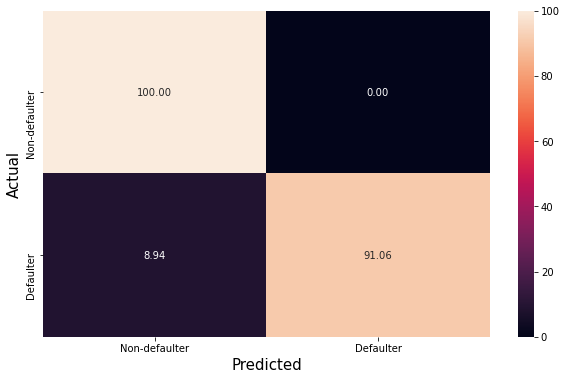

In [177]:
plot_confusion_matrix(test_targets_rf, y_pred_rf, 'CM_rf')

- Improvements have been seen for the classification of defaulter vs non-defaulter class (100% for non-defaulter and 91% for deafulter)
- Reduction in the number of falsely classifying a defaulter as non-defaulter (9%) and 0% for classifying a non-defaulter as defaulter


In [178]:
# Save results in dataframe
df_accuracy['RF'] = accuracy_rf
df_auc['RF'] = auc_roc_tf

#### Feature Importance

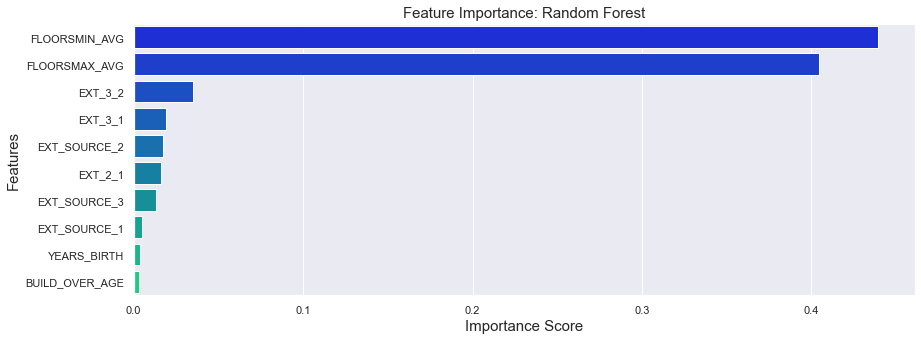

In [272]:
# Feature importance plot---top 10 features

feature_importance_rf = pd.DataFrame({'feature': list(train_inputs_rf.columns),
                   'importance': optimized_model_rf.feature_importances_}).\
                    sort_values('importance', ascending = False).iloc[0:10,:]

plt.figure(figsize=(14,5))
sns.set(style = "darkgrid")

ax = sns.barplot(
    x=feature_importance_rf.importance,
    y=feature_importance_rf.feature,
    data=feature_importance_rf,  
    palette='winter')

ax.set_ylabel("Features", fontsize=15)
ax.set_xlabel("Importance Score", fontsize=15)
plt.title("Feature Importance: Random Forest", fontsize=15)
plt.savefig("Figures/Model/Feature_importance_RF.png")
plt.show()

- Most important features found out by Random Forest model is surprisingly 'Floor area' of the house
- Second most important feature is the product of the unnamed features EXT 2 and 3. This was seen in the EDA step, where we found high correlation with target variable

### Model Performance with Top Five Features

#### Hyper Parameters

In [211]:
# Take top 5 features and create train, test, validation data
# train data
train_inputs_rf_top = train_inputs_rf[feature_importance_rf.feature[1:5]]
train_targets_rf_top = train_targets_rf

# test data
test_inputs_rf_top = test_inputs_rf[feature_importance_rf.feature[1:5]]
test_targets_rf_top = test_targets_rf


In [212]:
# Train model based on the hyperparameters from RandomGridSearch

model_rf_top = RandomizedSearchCV(estimator = RandomForestClassifier(random_state=42), 
                               scoring='roc_auc',
                               param_distributions = parameter_grid_rf, 
                               n_iter = 10, cv = 5, verbose=2, # 5 fold cross validation
                               random_state=42, n_jobs = -1)
# Fit the random search model
model_rf_top.fit(train_inputs_rf_top, train_targets_rf_top)

model_rf_top.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.1min finished


{'n_estimators': 149,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 5,
 'bootstrap': False}

In [213]:
optimized_model_rf_top = model_rf_top.best_estimator_

#### AUC

In [214]:
# probabilities
y_prob_rf_top = optimized_model_rf_top.predict_proba(test_inputs_rf_top.values)
        
# predicted class
y_pred_rf_top = y_prob_rf_top.argmax(axis=-1)
        
# calculate fpr, tpr
fpr_rf_top, tpr_rf_top, thresholds_rf_top = roc_curve(test_targets_rf_top, y_prob_rf_top[:,1], pos_label=1)
        
# calculate accuracy, AUC
accuracy_rf_top = accuracy_score(test_targets_rf_top, y_pred_rf_top)
auc_roc_rf_top = auc(fpr_rf_top, tpr_rf_top)


In [215]:
# accuracy, AUC
print('Test accuracy is: {:.2f}%'.format(100*accuracy_rf_top))
print('AUC-ROC value is: {:.4f}'.format(auc_roc_rf_top))

Test accuracy is: 95.57%
AUC-ROC value is: 0.9772


#### Confusion Matrix

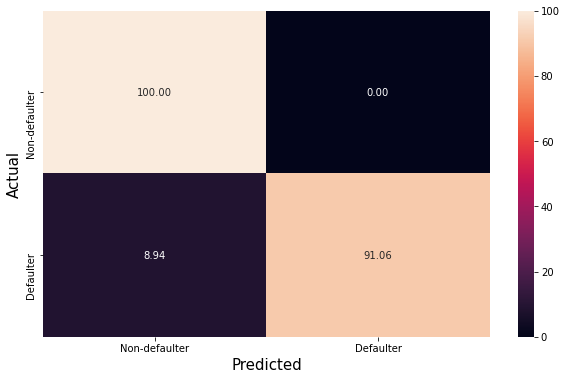

In [216]:
plot_confusion_matrix(test_targets_rf_top, y_pred_rf_top, 'CM_rf_top')

- The model with top 5 features yielded slightly better AUC score of 0.9772 but the FP and FN scores remained exactly same
- For the subsequent models we will still be suing full set of features as other algorithms can alter the top features

## GBM
Gradient Boosting Method (GBM) builds trees at a time. It learns from the weakness from previous tree and builds better trees along the way. Good for unbalanced data as the minority class gets weighted as the training goes on.

There are many parameters to tune  to get a optimized model. Many data scientist agree that number of trees, depth and learning are the three most important parameters. We will start with these three and then move to find other tree specific parameters and subsamples. 

[https://www.datacareer.de/blog/parameter-tuning-in-gradient-boosting-gbm/]

### Data Preparation
- Data was tweaked for standardized vs non-standardized version for simple random forest classifier
- Non standardized version yielded better AUC score, so we will be using non-standard data for thiss section

In [95]:
# Columns to keep
columns_to_keep = list(list(df_one_hot_code)+list(df_num.columns))
columns_to_keep = list(set(columns_to_keep)-set(['TARGET']))

# Train set
train_inputs_gbm = train_df[columns_to_keep]
train_targets_gbm = train_df['TARGET']

# Validation set
validation_inputs_gbm = validation_df[columns_to_keep]
validation_targets_gbm = validation_df['TARGET']

# Test set
test_inputs_gbm = test_df[columns_to_keep]
test_targets_gbm = test_df['TARGET']

In [96]:
# Append train and validation to one frame as the randomforest classifier 
# can cross validate by the specified times on the training data
train_inputs_gbm = pd.concat([train_inputs_gbm, validation_inputs_gbm])
train_targets_gbm= pd.concat([train_targets_gbm, validation_targets_gbm])

### Hyperparameter Optimization
Hyperparameters will be optimized in steps. This is to save huge computation time as running all the parameters might even take days to converge for training. At first, 'learning rate' and 'n_estimators' will be optimized. Based on the optimized learning rate and number of total trees, 'maximum depth' will be optimized.

In [99]:
# GBM hyper-parameter grid-----tune 'learning_rate' and 'n_estimators'
parameter_grid_gbm = {'n_estimators':[100,250,500, 750], 'learning_rate':[0.15,0.1,0.05, 0.01]}


model_gbm = GridSearchCV(estimator =GradientBoostingClassifier(max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10), 
            param_grid = parameter_grid_gbm, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

model_gbm.fit(train_inputs_gbm, train_targets_gbm)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=4,
                                                  max_features='sqrt',
                                                  random_state=10,
                                                  subsample=1),
             iid=False, n_jobs=4,
             param_grid={'learning_rate': [0.15, 0.1, 0.05, 0.01],
                         'n_estimators': [100, 250, 500, 750]},
             scoring='roc_auc')

In [100]:
# Take best 'learning rate' and 'n_estimators'

model_gbm.best_params_, model_gbm.best_score_

({'learning_rate': 0.01, 'n_estimators': 750}, 0.9772873720938702)

In [ ]:
# GBM hyper-parameter grid-----tune 'max_depth' with best 'eearning_rate' and 'n_estimators' found

parameter_grid_gbm = {'max_depth':[2,3,4,5,6,7]}


model_gbm = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.01,
                                                               n_estimators= 750,
                                                               max_depth=4, 
                                                               min_samples_split=2, 
                                                               min_samples_leaf=1, 
                                                               subsample=1,max_features='sqrt', random_state=10), 
            param_grid = parameter_grid_gbm, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

model_gbm.fit(train_inputs_gbm, train_targets_gbm)

In [92]:
# Best hyperparameters:

model_gbm.best_params_, model_gbm.best_score_

({'max_depth': 5}, 0.9774497762019292)

In [31]:
optimized_model_gbm = model_gbm.best_estimator_

### Metrics

#### AUC

In [35]:
# probabilities
y_prob_gbm = optimized_model_gbm.predict_proba(test_inputs_gbm.values)
        
# predicted class
y_pred_gbm = y_prob_gbm.argmax(axis=-1)
        
# calculate fpr, tpr
fpr_gbm, tpr_gbm, thresholds_gbm = roc_curve(test_targets_gbm, y_prob_gbm[:,1], pos_label=1)
        
# calculate accuracy, AUC
accuracy_gbm = accuracy_score(test_targets_gbm, y_pred_gbm)
auc_roc_gbm = auc(fpr_gbm, tpr_gbm)


In [36]:
# accuracy, AUC
print('Test accuracy is: {:.2f}%'.format(100*accuracy_gbm))
print('AUC-ROC value is: {:.4f}'.format(auc_roc_gbm))

Test accuracy is: 95.57%
AUC-ROC value is: 0.9811


#### Confusion Matrix

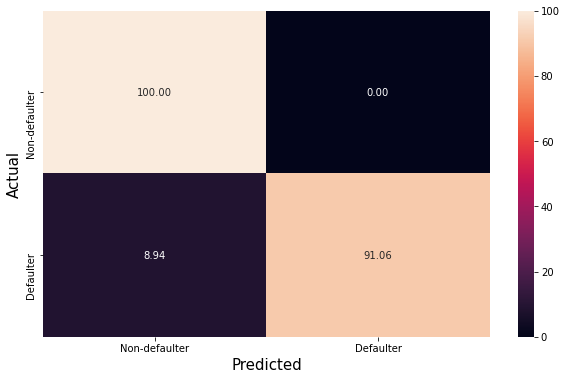

In [39]:
plot_confusion_matrix(test_targets_gbm, y_pred_gbm, 'CM_gbm')

- The FN/FP ratio remained same at 8.9 /0.0 %

In [55]:
# Save results in dataframe

df_accuracy['GBM'] = accuracy_gbm
df_auc['GBM'] = auc_roc_gbm

#### Feature Importance

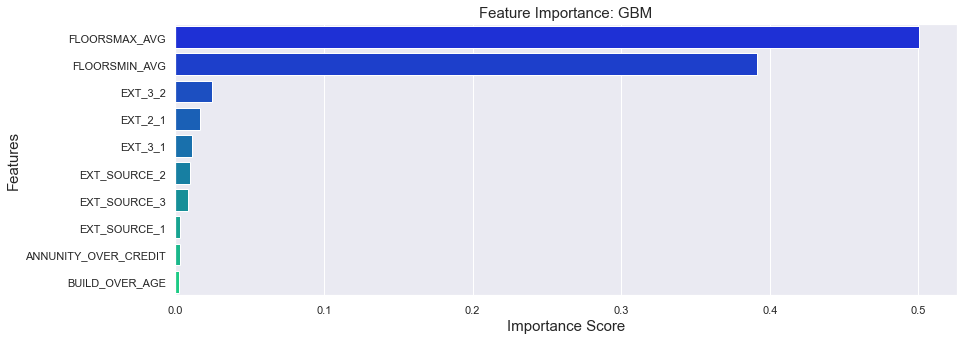

In [273]:
# Feature importance plot---top 10 features

feature_importance_gbm = pd.DataFrame({'feature': list(train_inputs_gbm.columns),
                   'importance': optimized_model_gbm.feature_importances_}).\
                    sort_values('importance', ascending = False).iloc[0:10,:]

plt.figure(figsize=(14,5))
sns.set(style = "darkgrid")

ax = sns.barplot(
    x=feature_importance_gbm.importance,
    y=feature_importance_gbm.feature,
    data=feature_importance_gbm,  
    palette='winter')

ax.set_ylabel("Features", fontsize=15)
ax.set_xlabel("Importance Score", fontsize=15)
plt.title("Feature Importance: GBM", fontsize=15)
plt.savefig("Figures/Model/Feature_importance_GBM.png")
plt.show()

- Similar to Random Forest, there are many overlapping between top features
- Floors area tops the list. In the EDA stage's Feature Creation section, it was indicated that more the spaces a client holds more likely to incline for taking loans to repay mortgage
- The next series of top features are multiplicative terms of 'EXT_' variables. In the EDA stage it was found that 'EXT_' variables have high correlations with target variables
- Amount of annuty has also effect on loan repayability, as annuity payment could pressure a client in taking loans
- House age over people's life span is also an important factor. Longer the house age, higher the duration people may tend to paying monthly mortgage

## XGBoost
XGBoost and GBM follow the same gradient boosting technique along the way. Only difference is XGBoost uses a more regularized model formalization to control overfitting. 

Similar to GBM, steb by step hyper parameter tuning will be done to cut huge computation time and resources. Intructions followed from here: [https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/]

### Data Preparation

In [101]:
# Columns to keep
columns_to_keep = list(list(df_one_hot_code)+list(df_num.columns))
columns_to_keep = list(set(columns_to_keep)-set(['TARGET']))

# Train set
train_inputs_xgb = train_df[columns_to_keep]
train_targets_xgb = train_df['TARGET']

# Validation set
validation_inputs_xgb = validation_df[columns_to_keep]
validation_targets_xgb = validation_df['TARGET']

# Test set
test_inputs_xgb = test_df[columns_to_keep]
test_targets_xgb = test_df['TARGET']

In [102]:
# Append train and validation to one frame as the randomforest classifier 
# can cross validate by the specified times on the training data
train_inputs_xgb = pd.concat([train_inputs_xgb, validation_inputs_xgb])
train_targets_xgb = pd.concat([train_targets_xgb, validation_targets_xgb])

### Hyperparameter Optimization
Hyperparameters will be optimized in steps. First best 'learning rate' and total trees (n_estimators) will be determined.

In [103]:
# XGB hyper-parameter grid-----tune 'learning_rate' and 'n_estimators'

param_grid_xgb = {"learning_rate": [0.05, 0.1, 0.15, .3],   # default is .3
                  "n_estimators": [50, 100, 150, 300]}

model_xgb = GridSearchCV(estimator = XGBClassifier(max_depth=5,
                                                   min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                   objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                         param_grid = param_grid_xgb, 
                         scoring='roc_auc',n_jobs=4,iid=False, cv=5) 

model_xgb.fit(train_inputs_xgb, train_targets_xgb)

model_xgb.best_params_, model_xgb.best_score_


({'learning_rate': 0.05, 'n_estimators': 150}, 0.9769332411844388)

- Take the best learning rate and number of trees and optimize 'max_depth' and 'min_child_weight' next

In [105]:
# XGB hyper-parameter grid-----tune 'max_depth' and 'min_child_weight'

param_grid_xgb = {"max_depth": [3, 4, 5, 10, 25],   # default is 6
                  'min_child_weight': [1, 2, 5]}    # default is 1

model_xgb = GridSearchCV(estimator = XGBClassifier(learning_rate = 0.05,
                                                   n_estimators = 150,
                                                   gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                   objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27),
                         param_grid = param_grid_xgb, 
                         scoring='roc_auc',n_jobs=4,iid=False, cv=5) 

model_xgb.fit(train_inputs_xgb, train_targets_xgb)

model_xgb.best_params_, model_xgb.best_score_


({'max_depth': 4, 'min_child_weight': 1}, 0.9770088090799269)

- Taking the best hyperparameters found so far, find out best 'num_leaves'  and 'gamma' parameter

In [106]:
# XGB hyper-parameter grid-----tune 'num_leaves' and 'gamma'

param_grid_xgb = {"num_leaves": [50, 100, 200],
                  'gamma': [0, 0.1, 0.5, 1.5]}      # default 0  

model_xgb = GridSearchCV(estimator = XGBClassifier(learning_rate = 0.05,
                                                   n_estimators = 150,
                                                   max_depth = 4,
                                                   min_child_weight = 1,
                                                   gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                   objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27),
                         param_grid = param_grid_xgb, 
                         scoring='roc_auc',n_jobs=4,iid=False, cv=5) 

model_xgb.fit(train_inputs_xgb, train_targets_xgb)

model_xgb.best_params_, model_xgb.best_score_


[16:37:14] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




({'gamma': 0.1, 'num_leaves': 50}, 0.9770224412512905)

- Now optimize 'subsample' and 'cosample_bytree' parameters

In [107]:
# XGB hyper-parameter grid-----tune 'subsample' and 'cosample_bytree'

param_grid_xgb = { 'subsample': [0.6, 0.8, 1.0],                   # default 1
                   'colsample_bytree': [0.9, 0.95, 1.0]}           # default 1     

model_xgb = GridSearchCV(estimator = XGBClassifier(learning_rate = 0.05,
                                                   n_estimators = 150,
                                                   max_depth = 4,
                                                   min_child_weight = 1,
                                                   num_leaves=50,
                                                   gamma=0.1, subsample=0.8, colsample_bytree=0.8,
                                                   objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27),
                         param_grid = param_grid_xgb, 
                         scoring='roc_auc',n_jobs=4,iid=False, cv=5) 

model_xgb.fit(train_inputs_xgb, train_targets_xgb)

model_xgb.best_params_, model_xgb.best_score_


[16:44:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




({'colsample_bytree': 0.9, 'subsample': 0.6}, 0.9770598570629652)

In [108]:
optimized_model_xgb = model_xgb.best_estimator_

### Metrics

#### AUC

In [109]:
# probabilities
y_prob_xgb = optimized_model_xgb.predict_proba(test_inputs_xgb.values)
        
# predicted class
y_pred_xgb = y_prob_xgb.argmax(axis=-1)
        
# calculate fpr, tpr
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(test_targets_xgb, y_prob_xgb[:,1], pos_label=1)
        
# calculate accuracy, AUC
accuracy_xgb = accuracy_score(test_targets_xgb, y_pred_xgb)
auc_roc_xgb = auc(fpr_xgb, tpr_xgb)


In [110]:
# accuracy, AUC
print('Test accuracy is: {:.2f}%'.format(100*accuracy_xgb))
print('AUC-ROC value is: {:.4f}'.format(auc_roc_xgb))

Test accuracy is: 95.61%
AUC-ROC value is: 0.9812


#### Confusion Matrix

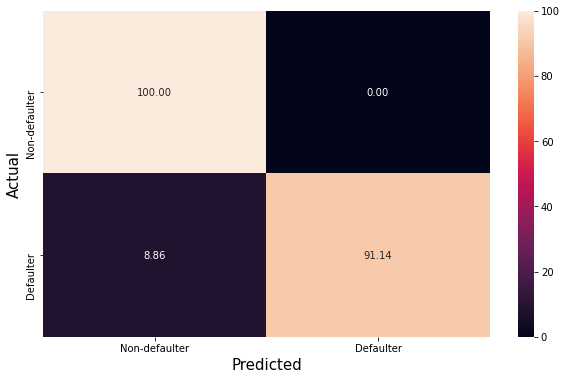

In [111]:
plot_confusion_matrix(test_targets_xgb, y_pred_xgb, 'CM_xgb')

- The FN/FP ratio remained same at 8.86/0.0 % althought his the lowest we got for the trained models

In [112]:
# Save results in dataframe
df_accuracy['XGB'] = accuracy_xgb
df_auc['XGB'] = auc_roc_xgb

#### Feature Importance

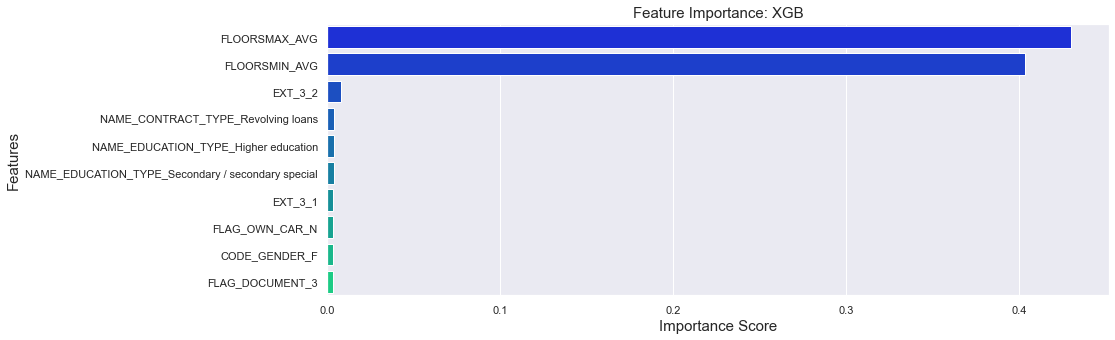

In [274]:
# Feature importance plot---top 10 features

feature_importance_xgb = pd.DataFrame({'feature': list(train_inputs_xgb.columns),
                   'importance': optimized_model_xgb.feature_importances_}).\
                    sort_values('importance', ascending = False).iloc[0:10,:]

plt.figure(figsize=(14,5))
sns.set(style = "darkgrid")

ax = sns.barplot(
    x=feature_importance_xgb.importance,
    y=feature_importance_xgb.feature,
    data=feature_importance_xgb,  
    palette='winter')

ax.set_ylabel("Features", fontsize=15)
ax.set_xlabel("Importance Score", fontsize=15)
plt.title("Feature Importance: XGB", fontsize=15)
plt.savefig("Figures/Model/Feature_importance_XGB.png")
plt.show()

- Similar to Random Forest and GBM models
- Floors area tops the list. In the EDA stage's Feature Creation section, it was indicated that more the spaces a client holds more likely to incline for taking loans to repay mortgage
- Multiplicative terms of 'EXT_' variables were seen as top features
- In case of revolving loan type, XGB model is suggesting to give importance
- In terms of education level, higher eucation and secondary education holders need to be put extra attention
- Additionally clients who do not own a car and female in gender also suggested by XGB model to pay extra attentions


### Ensemble Models
Take the average probabilities coming out of TF, RandomForest, GBM and XGB models to calculate AUC score

#### AUC

In [165]:
# probabilities
y_prob_ens = np.mean([y_prob_tf,y_prob_rf[:,1],y_prob_gbm[:,1],y_prob_xgb[:,1]], axis=0)
        
# predicted class
y_pred_ens = y_prob_ens.round()
        
# calculate fpr, tpr
fpr_ens, tpr_ens, thresholds_ens = roc_curve(test_targets_xgb, y_prob_ens, pos_label=1)
        
# calculate accuracy, AUC

accuracy_ens = accuracy_score(test_targets_xgb, y_pred_ens)

auc_roc_ens = auc(fpr_ens, tpr_ens)

In [166]:
# accuracy, AUC
print('Test accuracy is: {:.2f}%'.format(100*accuracy_ens))
print('AUC-ROC value is: {:.4f}'.format(auc_roc_ens))

Test accuracy is: 95.55%
AUC-ROC value is: 0.9809


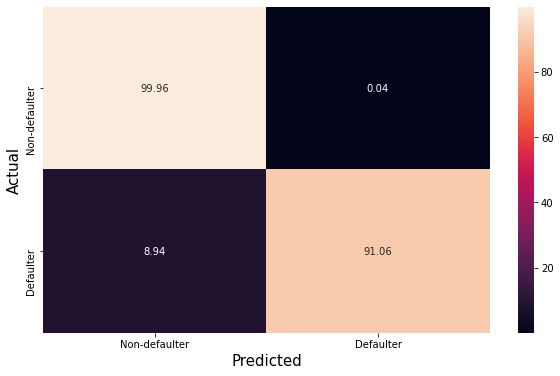

In [167]:
plot_confusion_matrix(test_targets_xgb, y_pred_ens, 'CM_ens')

- The FN/FP and TP/TN ratio remained similar to Random Forest, GBM and XGB models

In [217]:
# Save results in dataframe
df_accuracy['Ensemble'] = accuracy_ens
df_auc['Ensemble'] = auc_roc_ens

## Performance Comparison

### Accuracy

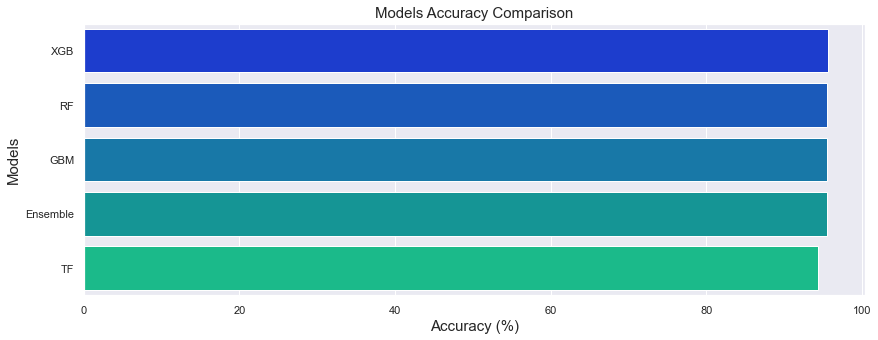

In [239]:
# Accuracy plot for all trained models

results_accuracy = df_accuracy.melt().sort_values(by=['value'], ascending=False)
results_accuracy['value'] = 100*results_accuracy['value']

plt.figure(figsize=(14,5))
sns.set(style = "darkgrid")

ax = sns.barplot(
    x=results_accuracy.value,
    y=results_accuracy.variable,
    data=results_accuracy,  
    palette='winter')

ax.set_ylabel("Models", fontsize=15)
ax.set_xlabel("Accuracy (%)", fontsize=15)
plt.title("Models Accuracy Comparison", fontsize=15)
plt.savefig("Figures/Model/Result_accuracy.png")
plt.show()

In [312]:
print('Maximum accuracy is: {:.2f}% for {} model'.format(results_accuracy.iloc[0,1], results_accuracy.iloc[0,0]))

Maximum accuracy is: 95.61% for XGB model


- Best accuracy score comes from XGB model whereas, ranked last is the Deep Neural Net model

### ROC Curve

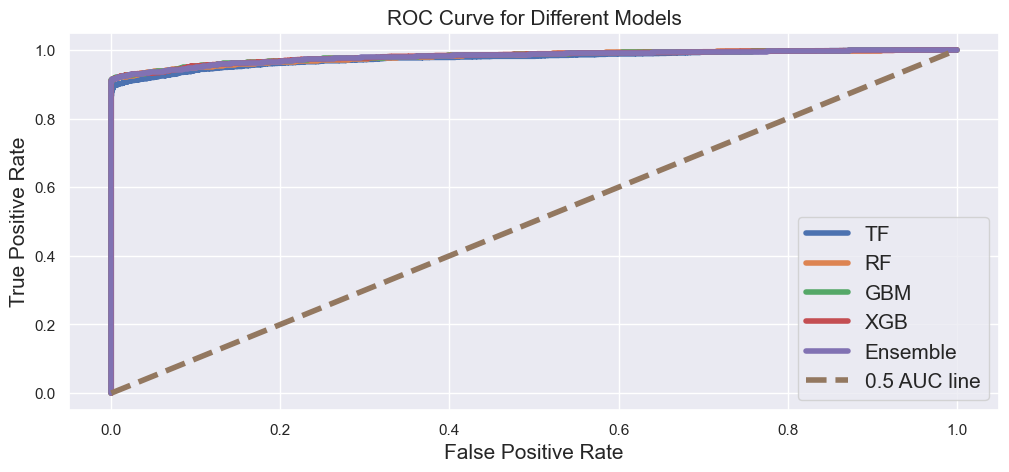

In [275]:
# ROC plot for all trained models

# plot the result

plt.figure(figsize=(12,5), dpi=100)
plt.title('ROC Curve for Different Models', fontsize=15)
plt.plot(fpr_tf, tpr_tf, linewidth=4, label='TF')
plt.plot(fpr_rf, tpr_rf, linewidth=4, label='RF')
plt.plot(fpr_gbm, tpr_gbm, linewidth=4, label='GBM')
plt.plot(fpr_xgb, tpr_xgb, linewidth=4, label='XGB')
plt.plot(fpr_ens, tpr_ens, linewidth=4, label='Ensemble')

plt.plot(np.linspace(0,1,20), np.linspace(0,1,20),'--', linewidth=4, label='0.5 AUC line')
plt.legend(loc='lower right', fontsize=15)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.savefig("Figures/Model/result_ROC.png")
plt.show()


- The ROC scores for all the hyperoptimized models are in the well above of the 0.5 AUC baseline

### AUC Score

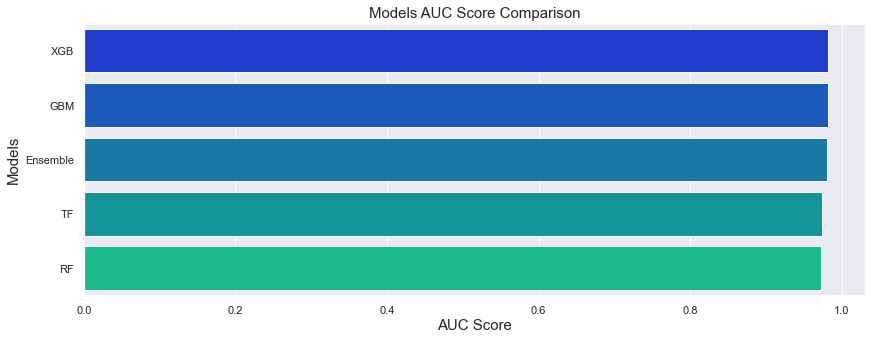

In [255]:
# AUC plot for all trained models

results_auc = df_auc.melt().sort_values(by=['value'], ascending=False)

plt.figure(figsize=(14,5))
sns.set(style = "darkgrid")

ax = sns.barplot(
    x=results_auc.value,
    y=results_auc.variable,
    data=results_auc,  
    palette='winter')

ax.set_ylabel("Models", fontsize=15)
ax.set_xlabel("AUC Score", fontsize=15)
plt.title("Models AUC Score Comparison", fontsize=15)
plt.savefig("Figures/Model/Result_auc.png")
plt.show()

In [257]:
print('Maximum AUC score is: {:.4f} for {} model'.format(results_auc.iloc[0,1], results_auc.iloc[0,0]))

Maximum AUC score is: 0.9812 for XGB model


- The AUC scores for all the hyperoptimized models are in the well above of excellent range (>0.9) 
- XGB has the highest AUC score with 0.9812 whereas RF ranked in the last

### Can the False Negative/False Positive ratio Get Better?
One effective way to balance between FN/FP is to tweak the threshold level by which a model predicts binary classes. Here, we will run ranges of threshold values and check if the confusion matrix improves. The best performed AUC scorer is XGB model. We willrun thresholding tests on the XGB model.

In [319]:
# predicted class

threshold = 0.2
y_pred_better = np.where(y_prob_xgb[:,1] > threshold, 1, 0)

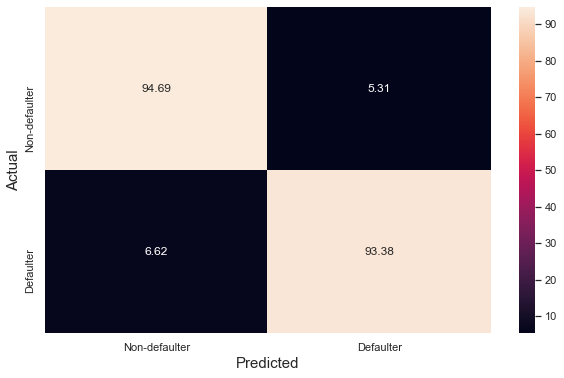

In [320]:
plot_confusion_matrix(test_targets_xgb, y_pred_better, 'CM_better')

In [307]:
threshold = [0.2, 0.3, 0.4, 0.5 , 0.6, 0.7]
fp = [5.31, 1.08, 0.2, 0, 0, 0]
fn = [6.62, 7.6, 8.61, 8.86, 8.94, 8.94]

- A threshold of 0.2 yields best balance between False positive and False negative ratio and True positive and True negative numbers (94/93 %)

### Save Best Model Parameters
Save the trained model parameters for XGB models

In [322]:
# Save XGB hyperparameter optimized model

file_name = "Models/xgb_class.pkl"

# save
pickle.dump(optimized_model_xgb, open(file_name, "wb"))

# 6. Conclusion
## Summary

- Home Credit Group's loan defaulter prediction was modelled with thousands of existing data
- Four algorithms were tried:
    - TensorFlow 2.0 (TF)
    - Random Forest (RF)
    - Gradient Boosting method (GBM)
    - Extreme Gradient Boosting (XGBoost)
- Dataset was made 'balanced' by under-sampling and 'shuffled' for making training ready
- Training, validation and testing set were split into 80-10-10 ratio
- Mainly, Area under curve (AUC) metric was used to measure the performance of binary classification in addition to Accuracy and Receiver Operating Characteristics (ROC) curve for better visualization

**TensorFLow**:
Different feture combinations were tried (category vs one-hot-encode, standard vs non-standard and manually created features). The combinations with 'one-hot-encoded' and 'standarded' features yielded best performances. A base model was trained and then 'hyperparameters' were optimized
   - **Base Model**: Made sure the model did not overfit by looking into validation (93.2%) and test accuracy (93.8%). An AUC score of 0.9718 was achieved with FN and FP ratio of 11 and 1 %. Although the AUC score is very good, FN is higher compared to FP. This means, the algorithm will allow more real loan defaulters to get loans than blocking real non-defaulters from getting loans.
   - **Hyperparameter Optimized Model**: AUC score of 0.9732 was achieved with accuracy of 94.43 %. This model yielded a slight decrease in FN/FP ratio of 10.69/0.12 %.
    
**Random Forest**:
Model was hyperparameter optimized and got the following results:
   - **Hyperparameter Optimized Model**:  A slight increase in accuracy score was found: 95.57 %. An AUC score of 0.9718 was achieved. FN/FP ratio is 8.9/0.0 %.
   - **Feature Importance**: Top important features suggested by the model are: 'Floor area', 'EXT_3_2', 'EXT_3_1', 'AGE' and 'BUILD_OVER_AGE'. 

**GBM**  
Model was optimized in steps and got the following results:
   - **Hyperparameter Optimized Model**: Same 'accuracy' score of 95.57 % was found as of Random Forest. A slight increase of AUC score was seen compared to Random Forest (0.9811). FN/FP ratio is same as of Random Forest model.
   - **Feature Importance**: Top important features suggested by the model are: 'Floor area', 'EXT_3_2', 'EXT_3_1', 'ANNUITY_OVER_CREDIT', 'BUILD_OVER_AGE'. Noticably most features overlap with Random Forest
    
**XGBoost**
Model was optimized in steps and got the following results:
   - **Hyperparameter Optimized Model**: We got a slight increase in 'accuracy' of 95.61% with associated AUC score of 0.9812. Slight improvement in FN/FP ratio was found 8.8/0.0 % compared to GBM model.
   - **Feature Importance**: Top important features influencing the loan defaulter decision suggested by the model are: 'Floor area', 'EXT_3_2', 'EXT_3_1','Revolving loan' in addition to 'non car owners' and 'female population'
   
**Ensemble**
Here, probabilities of the output classes from the above four models were averaged and prediction calculated. We got an 'accuracy' score of 95.55 % with AUC score of 0.9809. The FN/FP ratio found to be 8.9/0.04 %.

**Which Model has Got Best Metrics?**
XGBoost model has the highest AUC score of 0.9812 with 'accuracy' of 95.61 %. This means the model will be successful in rightly separing the two classes with 98.12 % probability which is an excellent score.

**Can We Get a Balanced Ratio between False Negative (FN) and False Positive (FP)?**
The best AUC score was found to be 0.9812 for XGBoost model. We tuned the 'threshold' of the classifier and observed with 0.2 threshold value, FN/FP ratio came to at 6.6/5.3 % and TN/TP ratio came to at 94/93 %.

This is an excellent result, as the classifier could reduce the number of real loan defaulters getting loan access with the cost of increased number of non-defaulters denying loan access. This way Home Credit Group can make a fine balance between these two opposing force which is the best interest for their objective.


## Future Recommendations

- Over sampling and synthetic data creation methodologies can be applied to balance the data and see if they improve performance
- Automatic feature engineering can be tried with additional data provided in the Kaggle competition
- Keras tuner can be used to see if it can improve TF model performance
- An app can be developed which can benefit similar organizations like Home Credit Group to provide automated and more accurate services to their clients